# Linear Prediction Models

The goal of the linear models is to create a benchmark for the prediction of tRCC gene effect scores for the top essential genes of interest found using models trained on various DepMap CCL datasets. Since the number of tRCC samples is small in this dataset, we will assess how successfully linear models trained generally across all types of DepMap CCLs is in predicting gene effect scores for tRCC.

Firstly, the datasets are preprocessed, cleaned, and standardised for training and analysis. There are four datasets used in the analysis: 
- DepMap Gene Expression - (full dataset, RCC CCLs, ccRCC CCLs)
- DepMap Gene Effects - (full dataset, RCC CCLs, ccRCC CCLs)
- tRCC Gene Expression
- tRCC Gene Effects

There are also two sets of genes of interest:
- Top Common Essential Genes - these are the common essential genes found that are highly negtatively selective for tRCC across all the dependency analyses 
- Top Essential Genes - these are the top 100 essential genes found that are highly negatively selective for tRCC between all the dependency analyses

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression 
import os
import linear_functions as lf

## Preprocessing Omics and CRISPR Screening Datasets across DepMap CCLs (all CCLs, RCC, ccRCC) and tRCC CCLs

In [2]:
### Script Parameters
#####################

random_state = 1
test_size = 0.2

In [3]:
### DepMap Gene Expression (TPMLogp1)
#####################################
depmap_gene_exp_23Q2 = pd.read_csv("../../datasets/depmap_datasets/23Q2/OmicsExpressionProteinCodingGenesTPMLogp1.csv")
depmap_gene_exp_23Q2.set_index("Unnamed: 0", inplace=True)
depmap_gene_exp_23Q2.index.name = None
depmap_gene_exp_23Q2.sort_index(axis=0, inplace=True)
depmap_gene_exp_23Q2.sort_index(axis=1, inplace=True)
depmap_gene_exp_23Q2.dropna(axis=1, inplace=True)
depmap_gene_exp_23Q2.columns = lf.ExtractGenesNames(depmap_gene_exp_23Q2.columns)

### DepMap Gene Effects (CHRONOS)
#################################
depmap_gene_effect_23Q2 = pd.read_csv('../../datasets/depmap_datasets/23Q2/CRISPRGeneEffect.csv')
depmap_gene_effect_23Q2.set_index("ModelID", inplace=True)
depmap_gene_effect_23Q2.index.name = None
depmap_gene_effect_23Q2.sort_index(axis=0, inplace=True)
depmap_gene_effect_23Q2.sort_index(axis=1, inplace=True)
depmap_gene_effect_23Q2.dropna(axis=1, inplace=True)
depmap_gene_effect_23Q2.columns = lf.ExtractGenesNames(depmap_gene_effect_23Q2.columns)

### TRCC Gene Expression (TPMLogp1)
###################################
DFCI_gene_exp = pd.read_csv("../../datasets/tRCC_cell_lines/raw/RSEM_summary_all_samples_gene_TPM.txt", sep="\t").set_index("gene_id")

STFE1 = pd.read_csv("../../datasets/tRCC_cell_lines/raw/F1.genes.results", sep="\t").set_index("gene_id")["TPM"]
STFE2 = pd.read_csv("../../datasets/tRCC_cell_lines/raw/F2.genes.results", sep="\t").set_index("gene_id")["TPM"]
STFE3 = pd.read_csv("../../datasets/tRCC_cell_lines/raw/F3.genes.results", sep="\t").set_index("gene_id")["TPM"]
STFE_means = pd.concat([STFE1, STFE2, STFE3], axis=1).dropna(axis=1).mean(axis=1)
STFE_means.name = "STFE"

FUUR1_means = DFCI_gene_exp[['B19', 'B20', 'B21']].mean(axis=1)
UOK109_means = DFCI_gene_exp[['B10', 'B11', 'B12']].mean(axis=1)

tRCC_gene_exp = pd.DataFrame({
    'FUUR1': FUUR1_means,
    'UOK109': UOK109_means
}, index=DFCI_gene_exp.index)

tRCC_gene_exp = tRCC_gene_exp.join(STFE_means, how="outer")

tRCC_gene_exp.index.name = None
tRCC_gene_exp.index = tRCC_gene_exp.index.str.split('_').str[-1]
tRCC_gene_exp.sort_index(axis=0, inplace=True)
tRCC_gene_exp.sort_index(axis=1, inplace=True)
tRCC_gene_exp = np.log1p(tRCC_gene_exp)
tRCC_gene_exp = tRCC_gene_exp.groupby(tRCC_gene_exp.index).sum().T
tRCC_gene_exp.to_csv("../../datasets/tRCC_cell_lines/tRCC_gene_exp_TPMLogp1.csv")

### TRCC Gene Effects (CHRONOS)
###############################
DFCI_chronos_dataset = pd.read_csv("../../datasets/tRCC_cell_lines/Chronos/tRCC_chronos_summary_for_BL_ASPS_updated.csv")
DFCI_chronos_CCLs = DFCI_chronos_dataset[["Gene", "PC3", "CAKI2", "CAKI1", "786O", "DU145", "HCT116", "NCIH460", "FUUR1", "STFE", "UOK109"]].T
DFCI_chronos_CCLs.columns = DFCI_chronos_CCLs.iloc[0]
DFCI_chronos_CCLs.columns.name = None
DFCI_chronos_CCLs.drop(DFCI_chronos_CCLs.index[0], inplace=True)
DFCI_chronos_CCLs = DFCI_chronos_CCLs.loc[:, ~(DFCI_chronos_CCLs == 'Unknown').any(axis=0)].apply(pd.to_numeric, errors='coerce').dropna(axis=1)

tRCC_chronos_gene_effects = DFCI_chronos_CCLs.loc[["FUUR1", "STFE", "UOK109"]]
tRCC_chronos_gene_effects.sort_index(axis=0, inplace=True)
tRCC_chronos_gene_effects.sort_index(axis=1, inplace=True)

### Standardise Rows and Columns Between dataframes
###################################################
depmap_gene_exp_23Q2, depmap_gene_effect_23Q2 = lf.Intersect_DF([depmap_gene_exp_23Q2, depmap_gene_effect_23Q2])
tRCC_gene_exp, tRCC_chronos_gene_effects = lf.Intersect_DF([tRCC_gene_exp, tRCC_chronos_gene_effects])
depmap_gene_exp_23Q2, depmap_gene_effect_23Q2, tRCC_gene_exp, tRCC_chronos_gene_effects = lf.Intersect_DF([depmap_gene_exp_23Q2, depmap_gene_effect_23Q2, tRCC_gene_exp, tRCC_chronos_gene_effects], match="columns")

print("DepMap dataset row/column check: ", lf.Check_DF_Similarity([depmap_gene_exp_23Q2, depmap_gene_effect_23Q2]))
print("tRCC dataset row/column check: ", lf.Check_DF_Similarity([tRCC_gene_exp, tRCC_chronos_gene_effects]))
print("Check columns across DepMap and tRCC dataframes: ", lf.Check_DF_Similarity([depmap_gene_exp_23Q2, depmap_gene_effect_23Q2, tRCC_gene_exp, tRCC_chronos_gene_effects], check="columns"))

### DepMap RCC CCLs
##########################
depmap_RCC_data = pd.read_csv("../../datasets/depmap_datasets/CCLIDs/RCC_depmap_data.csv")
RCC_depmap_gene_exp_23Q2 = depmap_gene_exp_23Q2[depmap_gene_exp_23Q2.index.isin(depmap_RCC_data["depmapId"])]
RCC_depmap_gene_effect_23Q2 = depmap_gene_effect_23Q2[depmap_gene_effect_23Q2.index.isin(depmap_RCC_data["depmapId"])]

### DepMap ccRCC CCls
############################
depmap_ccRCC_data = pd.read_csv('../../datasets/depmap_datasets/CCLIDs/ccRCC_depmap_data.csv')
ccRCC_depmap_gene_exp_23Q2 = depmap_gene_exp_23Q2[depmap_gene_exp_23Q2.index.isin(depmap_ccRCC_data["depmapId"])]
ccRCC_depmap_gene_effect_23Q2 = depmap_gene_effect_23Q2[depmap_gene_effect_23Q2.index.isin(depmap_ccRCC_data["depmapId"])]

### Train-Test Datasets
#######################
depmap_X_train, depmap_X_test, depmap_Y_train, depmap_Y_test = train_test_split(depmap_gene_exp_23Q2, depmap_gene_effect_23Q2, test_size=test_size, random_state=random_state)
RCC_X_train, RCC_X_test, RCC_Y_train, RCC_Y_test = train_test_split(RCC_depmap_gene_exp_23Q2, RCC_depmap_gene_effect_23Q2, test_size=test_size, random_state=random_state)
ccRCC_X_train, ccRCC_X_test, ccRCC_Y_train, ccRCC_Y_test = train_test_split(ccRCC_depmap_gene_exp_23Q2, ccRCC_depmap_gene_effect_23Q2, test_size=test_size, random_state=random_state)

### Essential Genes
###################
top_common_essential_genes = pd.read_csv("../../analysis/testGenes/top_common_essential_genes")["gene"]
top100_essential_genes = pd.read_csv("../../analysis/testGenes/top_essential_genes")["Gene"]

DepMap dataset row/column check:  {'all_match': True, 'column_differences': [[], []], 'row_differences': [[], []]}
tRCC dataset row/column check:  {'all_match': True, 'column_differences': [[], []], 'row_differences': [[], []]}
Check columns across DepMap and tRCC dataframes:  {'all_match': True, 'column_differences': [[], [], [], []]}


## Linear Model Predictions on DepMap CCLs

### Linear Models across full DepMap CCLs Training/Testing subsets

In [4]:
depmap_top_100_essential_gene_linearity = lf.GeneLinearity(depmap_X_train, depmap_Y_train, top100_essential_genes)

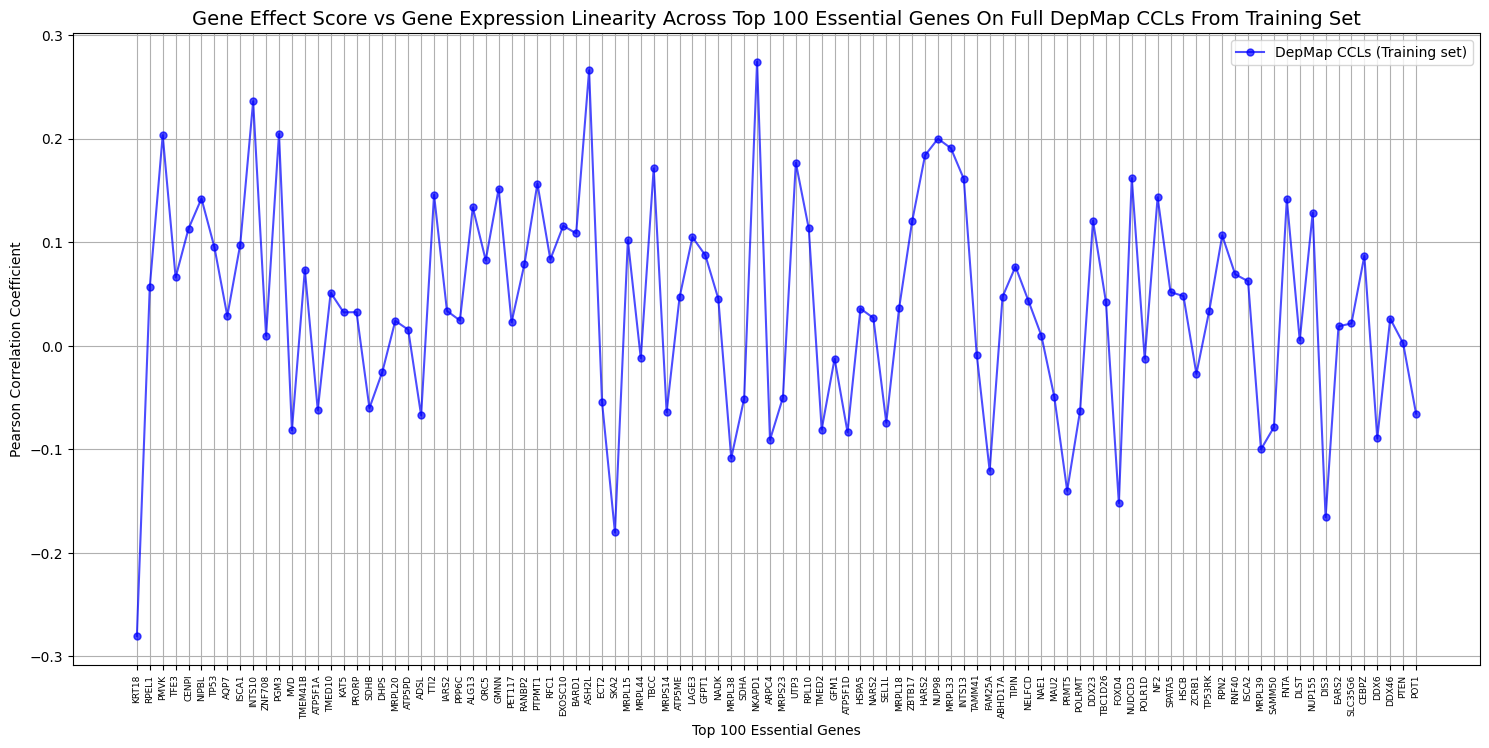

Mean absolute Pearson Correlation Coefficients across top 100 essential genes: 0.08920429254256008


In [5]:
lf.LinePlot(depmap_top_100_essential_gene_linearity, 
            {"Linearity": "blue"}, 
            axes_labels=["Top 100 Essential Genes", 
                         "Pearson Correlation Coefficient"], 
            main_title="Gene Effect Score vs Gene Expression Linearity Across Top 100 Essential Genes On Full DepMap CCLs From Training Set",
            legend_titles={"corr": "DepMap CCLs (Training set)"})

print("Mean absolute Pearson Correlation Coefficients across top 100 essential genes: {0}".format(abs(depmap_top_100_essential_gene_linearity["corr"]).mean()))

In [6]:
depmap_top100_essential_gene_models = lf.ComputeGeneLinearModels(depmap_X_train, depmap_Y_train, top100_essential_genes)
depmap_top100_essential_gene_preds, depmap_top100_essential_gene_RMSE = lf.ComputeGenePredictions(depmap_X_test, depmap_Y_test, depmap_top100_essential_gene_models)

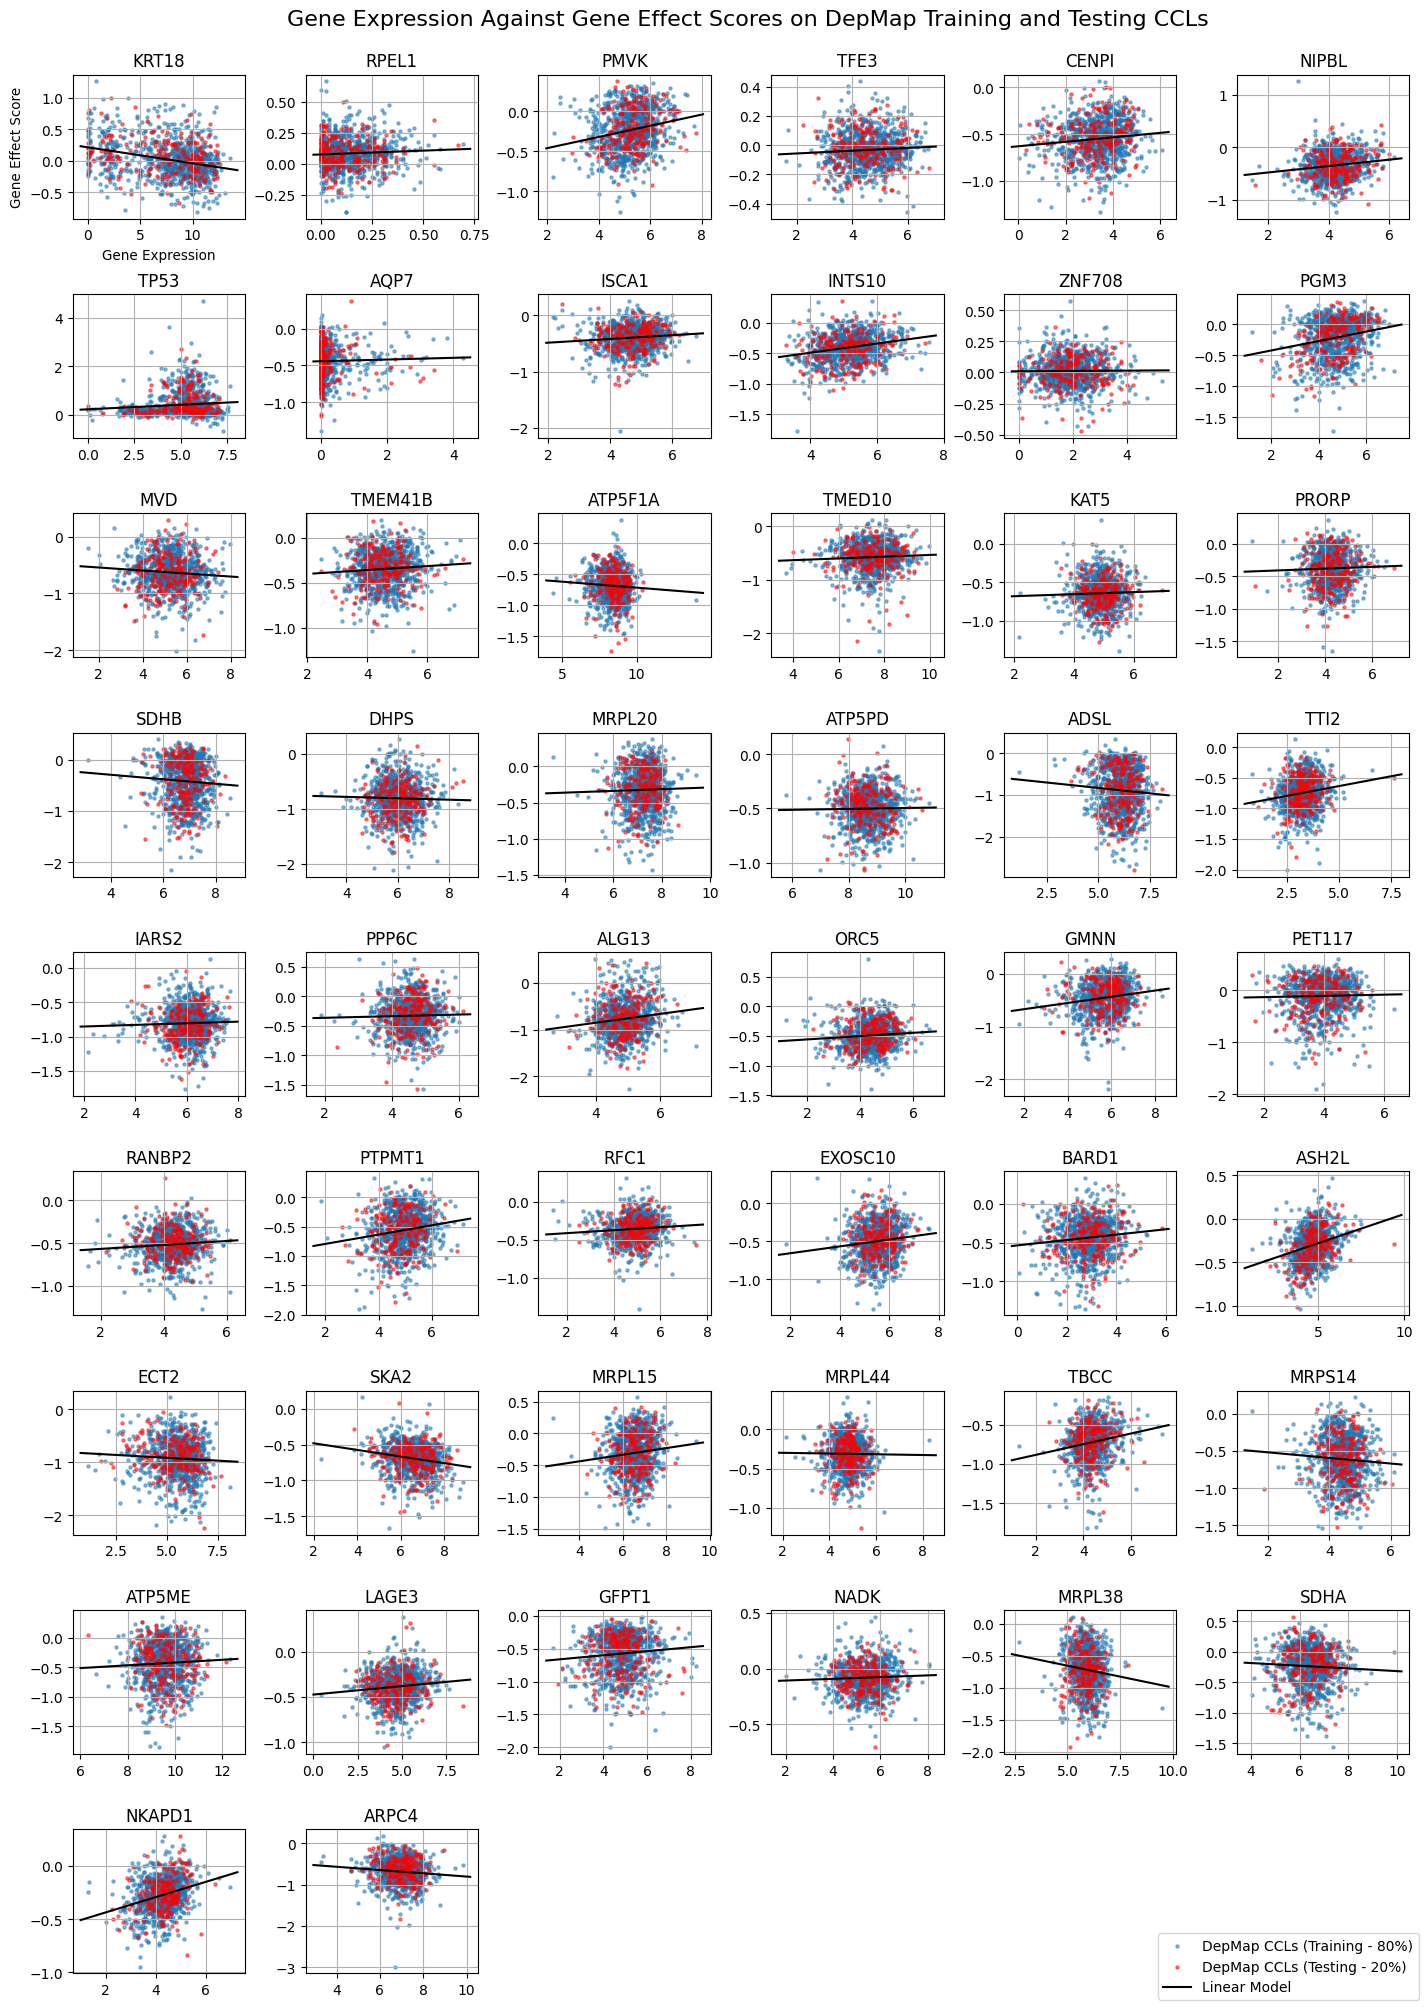

In [7]:
lf.GeneRelMiniPlot(depmap_X_train, depmap_Y_train, top100_essential_genes[:50],
                   rel2_X=depmap_X_test,
                   rel2_Y=depmap_Y_test,
                   models=depmap_top100_essential_gene_models,
                   main_title="Gene Expression Against Gene Effect Scores on DepMap Training and Testing CCLs",
                   axes_labels=["Gene Expression", "Gene Effect Score"],
                   axis_label_fontsize=9.75,
                   legend_titles={
                       "rel1": "DepMap CCLs (Training - 80%)", "rel2": "DepMap CCLs (Testing - 20%)", "model": "Linear Model"},
                   sizeProps=[0.9475, 0.01, 0.99, 0],
                   wspace=0.35,
                   hspace=0.525)

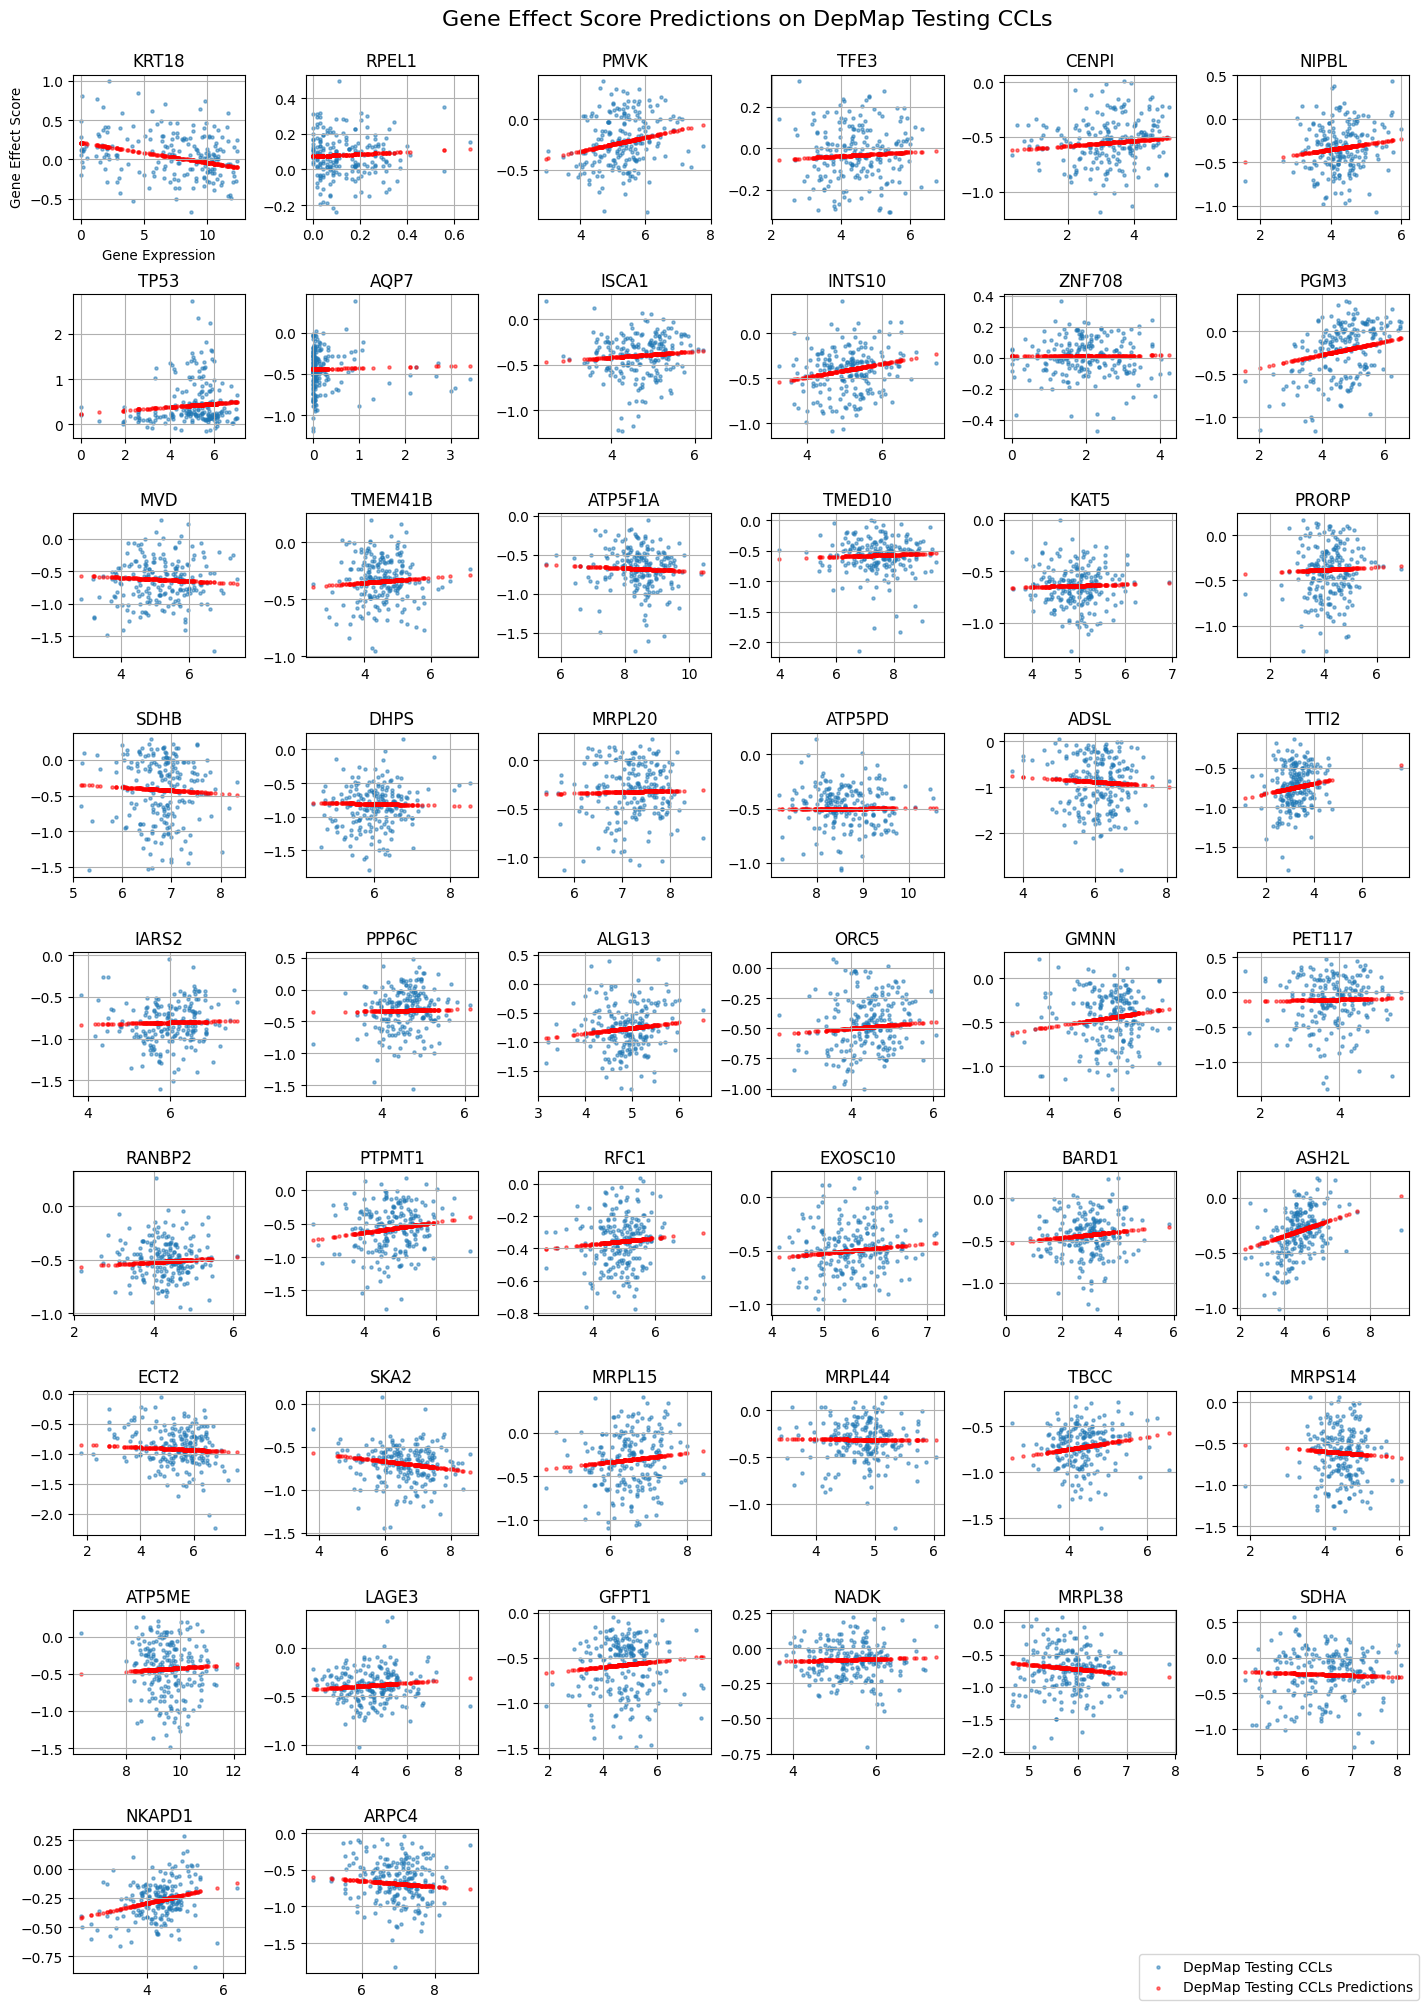

In [8]:
lf.GeneRelMiniPlot(depmap_X_test, depmap_Y_test, top100_essential_genes[:50],
                   rel2_X=depmap_X_test,
                   rel2_Y=depmap_top100_essential_gene_preds,
                   main_title="Gene Effect Score Predictions on DepMap Testing CCLs",
                   axes_labels=["Gene Expression", "Gene Effect Score"],
                   axis_label_fontsize=9.75,
                   legend_titles={
                       "rel1": "DepMap Testing CCLs", "rel2": "DepMap Testing CCLs Predictions"},
                   sizeProps=[0.9475, 0.01, 0.99, 0],
                   wspace=0.35,
                   hspace=0.525)

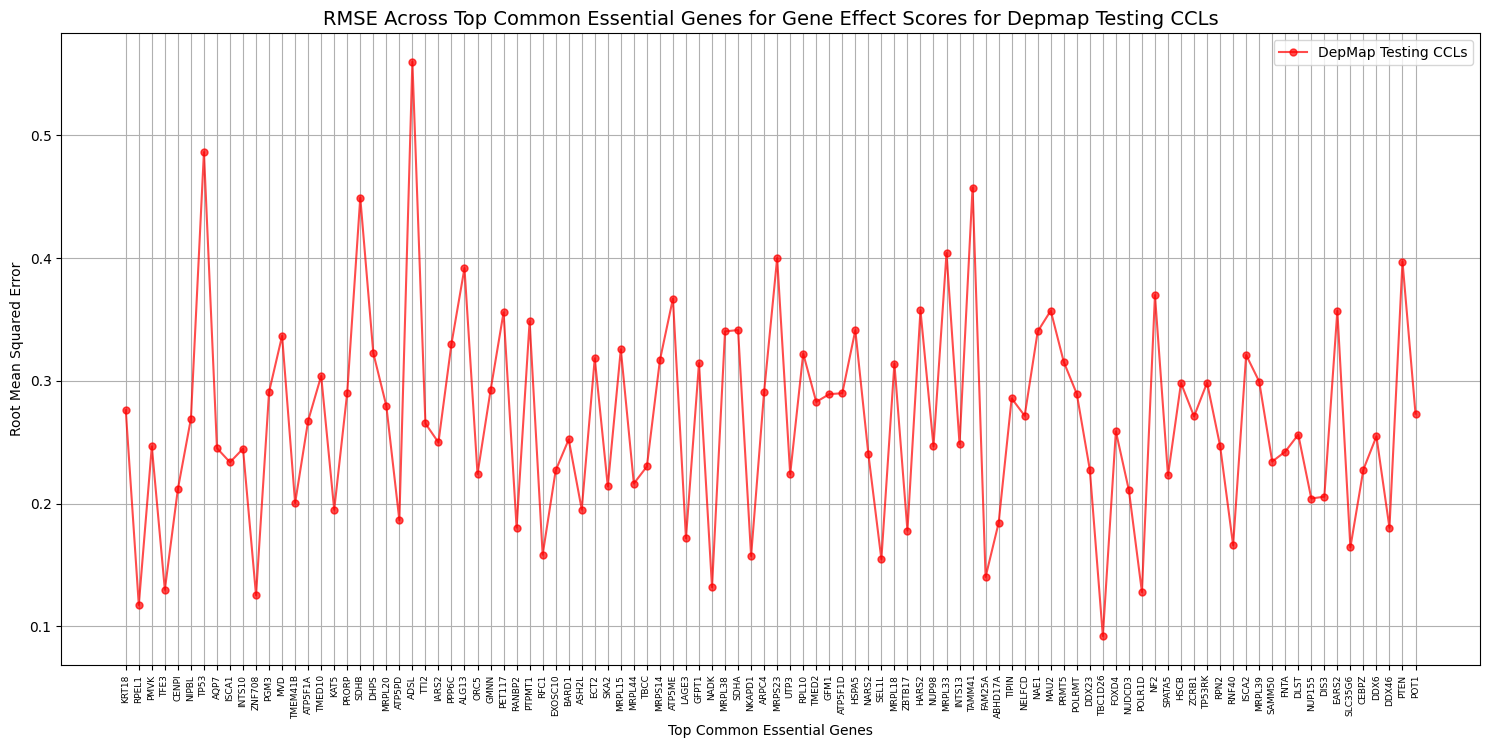

In [9]:
lf.LinePlot(depmap_top100_essential_gene_RMSE, 
            {"RMSE": "red"}, 
            axes_labels=["Top Common Essential Genes", 
                         "Root Mean Squared Error"], 
            main_title="RMSE Across Top Common Essential Genes for Gene Effect Scores for Depmap Testing CCLs",
            legend_titles={"RMSE": "DepMap Testing CCLs"})

In [10]:
print("Average RMSE for predicted gene effect scores on testing subset of DepMap CCLs: {0:.4}".format(depmap_top100_essential_gene_RMSE["RMSE"].mean()))

Average RMSE for predicted gene effect scores on testing subset of DepMap CCLs: 0.2681


### Linear Models across RCC DepMap CCLs Training/Testing subsets

In [11]:
RCC_top_100_essential_gene_linearity = lf.GeneLinearity(RCC_X_train, RCC_Y_train, top100_essential_genes)

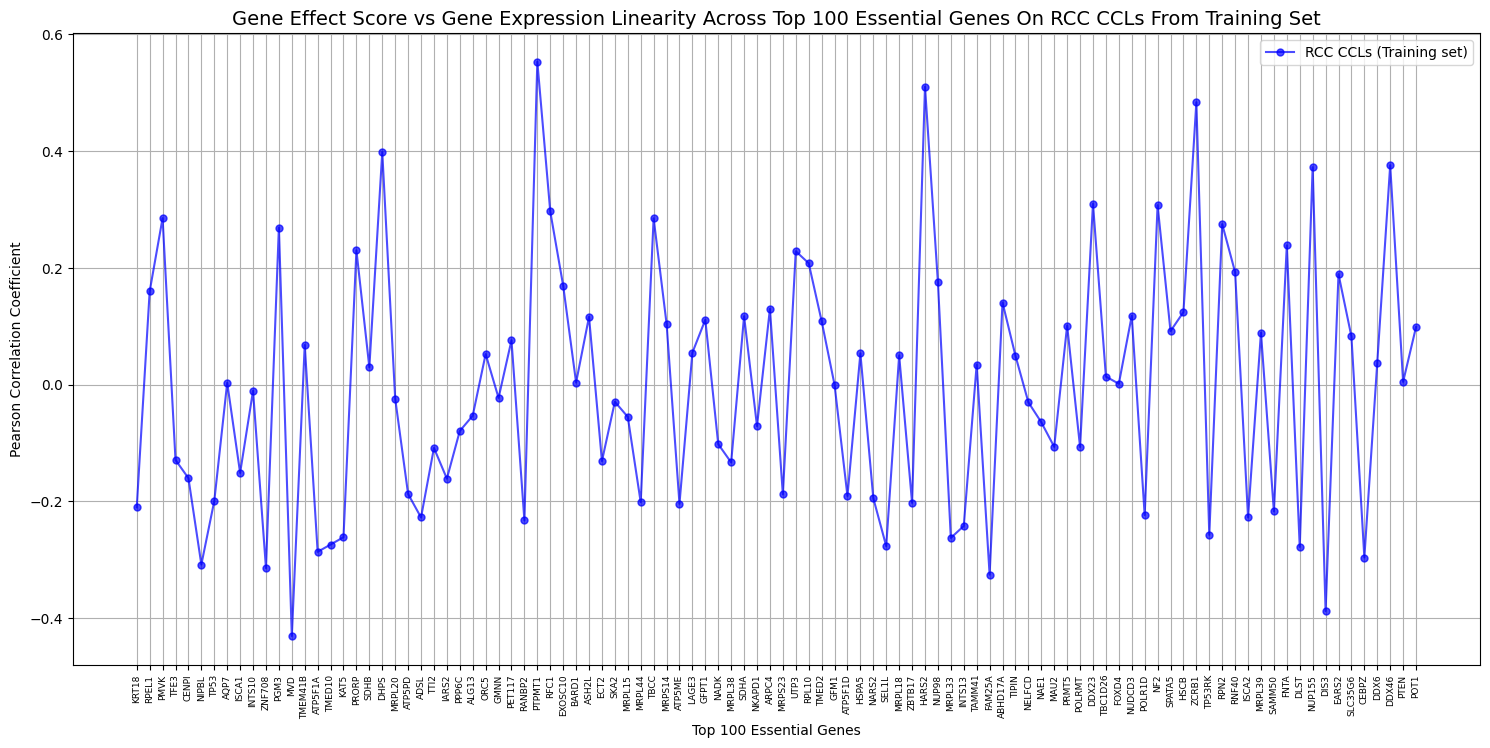

Mean Pearson Correlation Coefficients across top 100 essential genes: 0.17405519855107726


In [12]:
lf.LinePlot(RCC_top_100_essential_gene_linearity, 
            {"Linearity": "blue"}, 
            axes_labels=["Top 100 Essential Genes", 
                         "Pearson Correlation Coefficient"], 
            main_title="Gene Effect Score vs Gene Expression Linearity Across Top 100 Essential Genes On RCC CCLs From Training Set",
            legend_titles={"corr": "RCC CCLs (Training set)"})

print("Mean Pearson Correlation Coefficients across top 100 essential genes: {0}".format(abs(RCC_top_100_essential_gene_linearity["corr"]).mean()))

In [13]:
RCC_top100_essential_gene_models = lf.ComputeGeneLinearModels(RCC_X_train, RCC_Y_train, top100_essential_genes)
RCC_top100_essential_gene_preds, RCC_top100_essential_gene_RMSE = lf.ComputeGenePredictions(RCC_X_test, RCC_Y_test, RCC_top100_essential_gene_models)

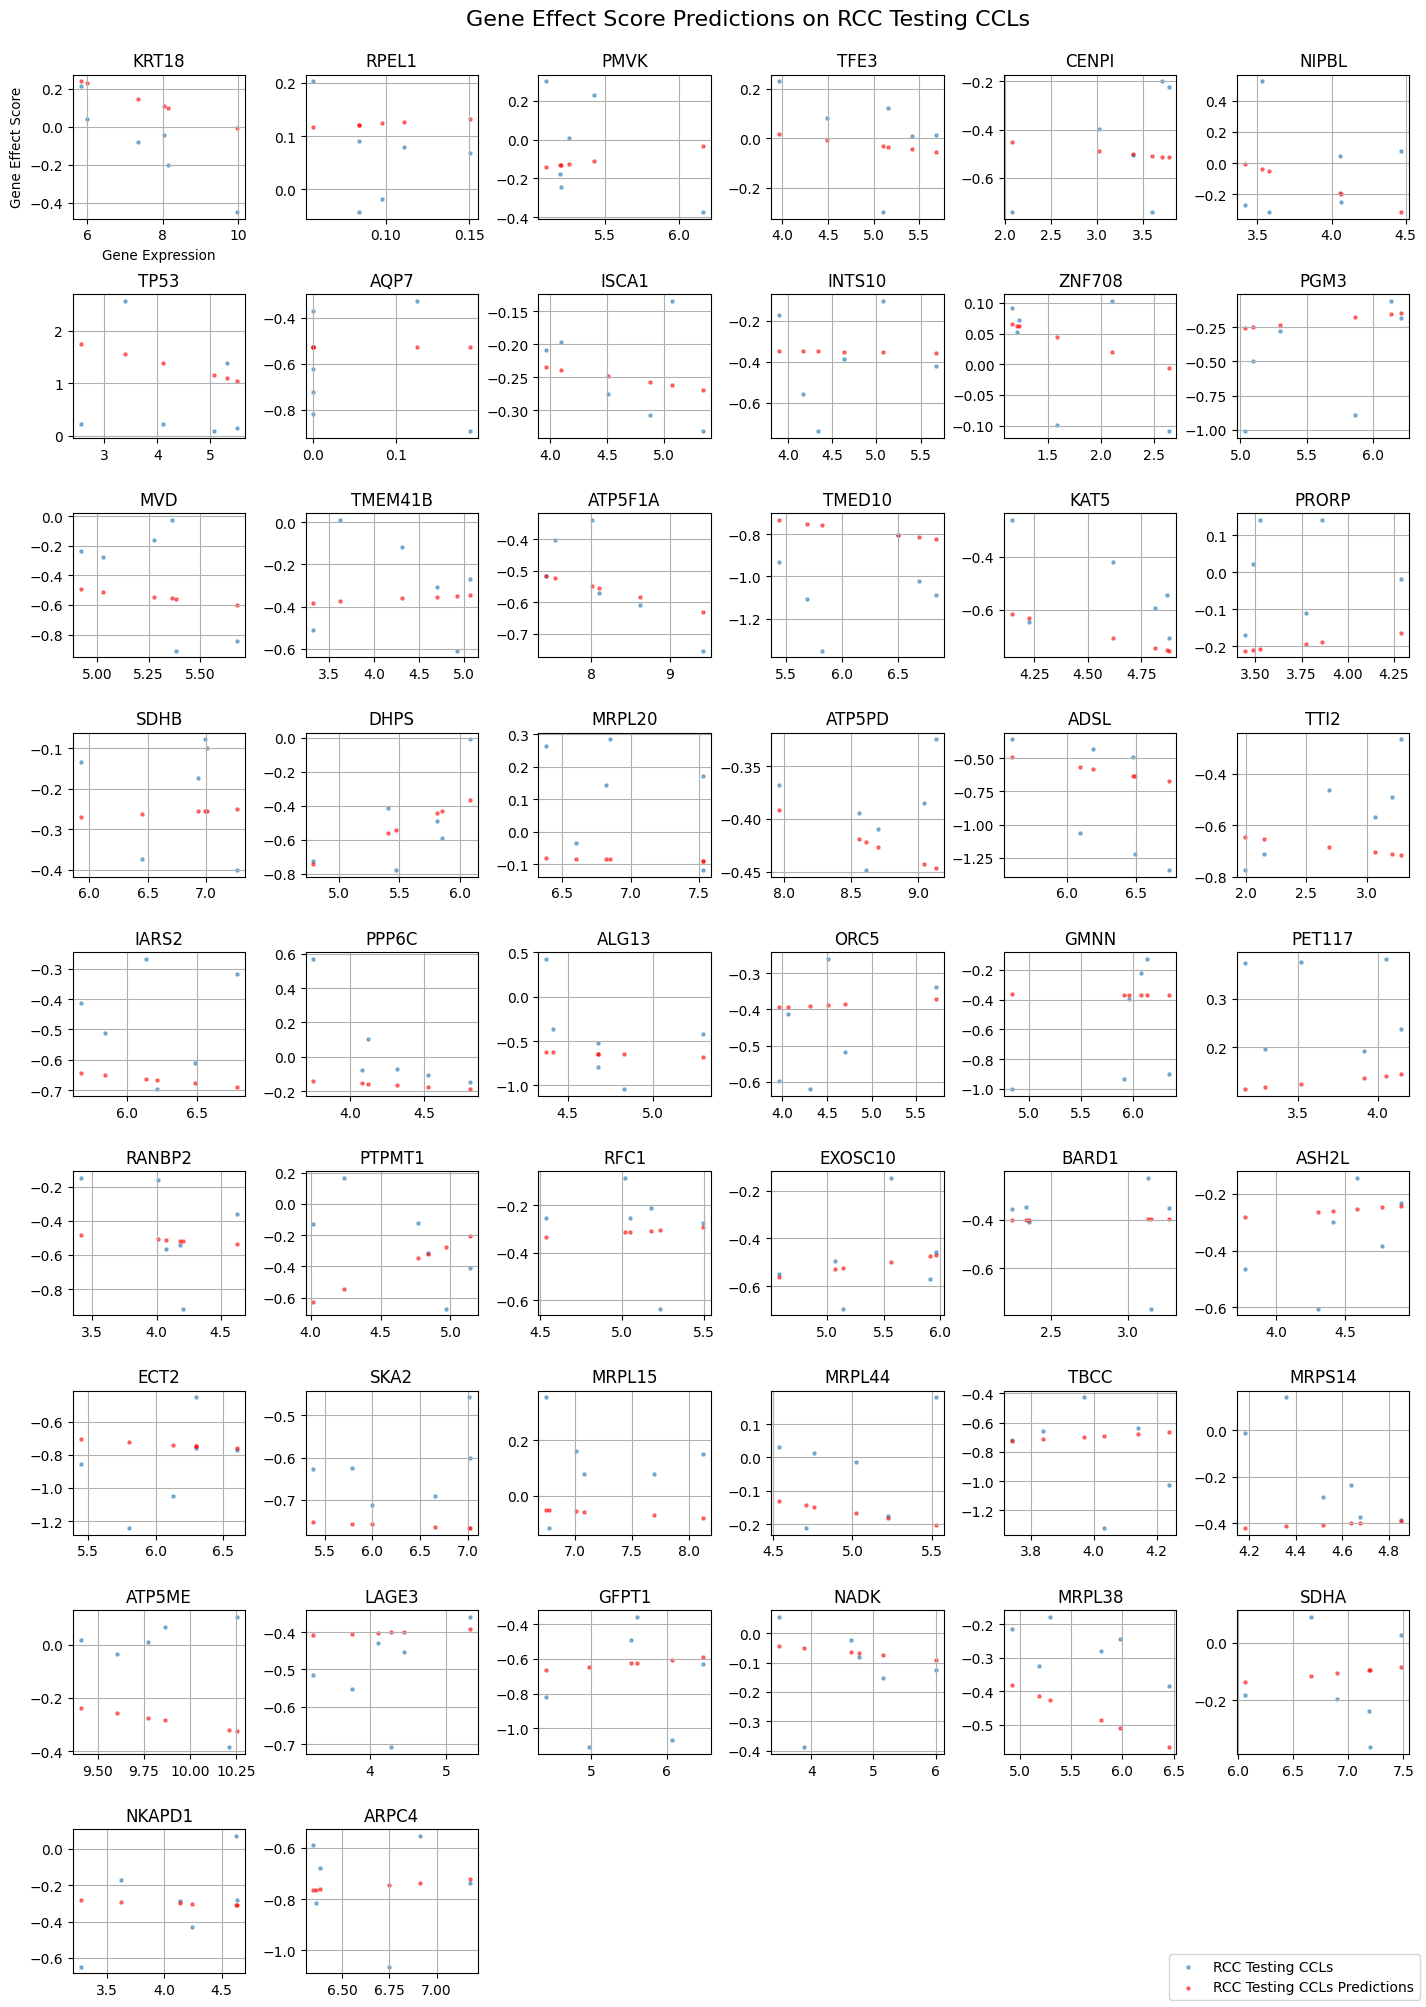

In [14]:
lf.GeneRelMiniPlot(RCC_X_test, RCC_Y_test, top100_essential_genes[:50],
                   rel2_X=RCC_X_test,
                   rel2_Y=RCC_top100_essential_gene_preds,
                   main_title="Gene Effect Score Predictions on RCC Testing CCLs",
                   axes_labels=["Gene Expression", "Gene Effect Score"],
                   axis_label_fontsize=9.75,
                   legend_titles={
                       "rel1": "RCC Testing CCLs", "rel2": "RCC Testing CCLs Predictions"},
                   sizeProps=[0.9475, 0.01, 0.99, 0],
                   wspace=0.35,
                   hspace=0.525)

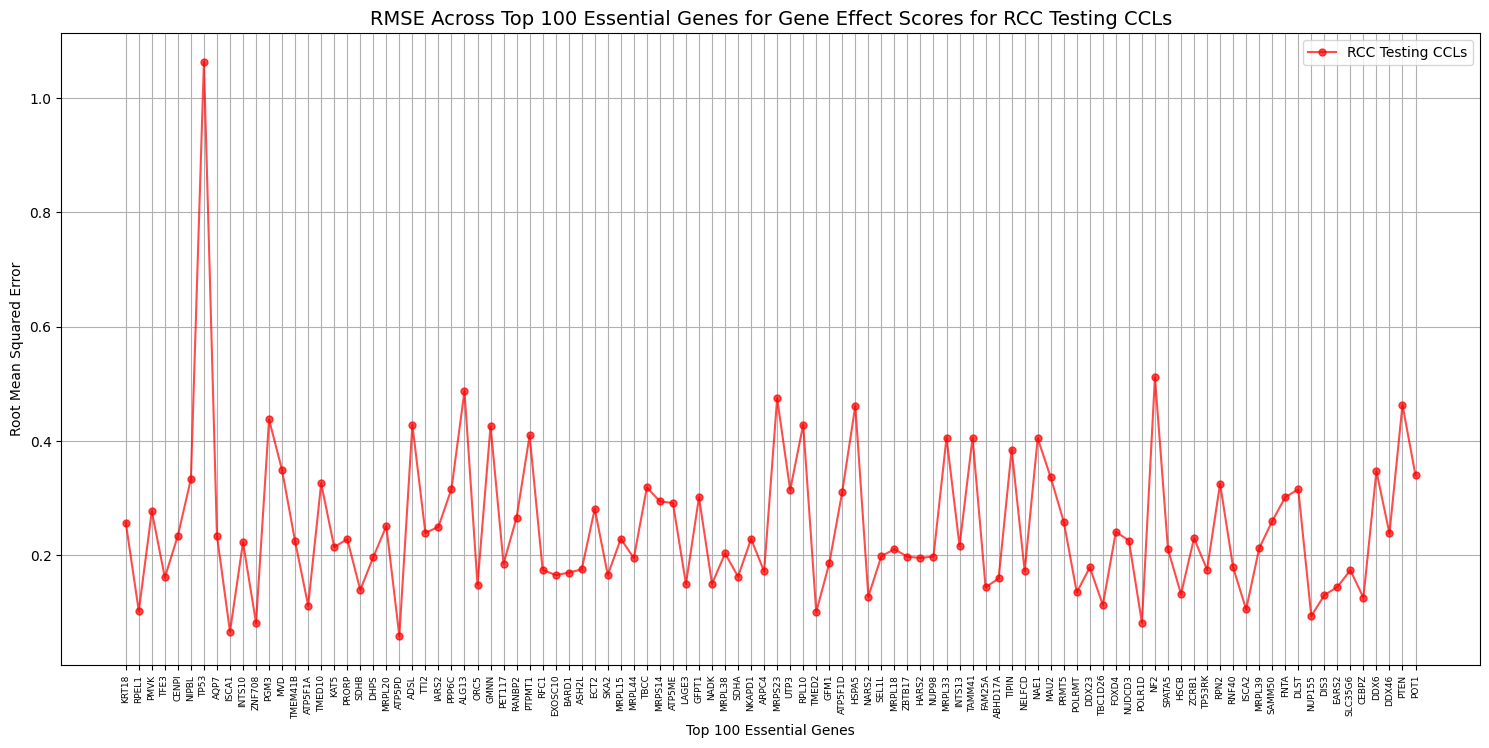

In [15]:
lf.LinePlot(RCC_top100_essential_gene_RMSE, 
            {"RMSE": "red"}, 
            axes_labels=["Top 100 Essential Genes", 
                         "Root Mean Squared Error"], 
            main_title="RMSE Across Top 100 Essential Genes for Gene Effect Scores for RCC Testing CCLs",
            legend_titles={"RMSE": "RCC Testing CCLs"})

In [16]:
print("Average RMSE for predicted gene effect scores on testing subset of RCC CCLs: {0:.4}".format(RCC_top100_essential_gene_RMSE["RMSE"].mean()))

Average RMSE for predicted gene effect scores on testing subset of RCC CCLs: 0.2479


### Linear Models across ccRCC DepMap CCLs Training/Testing subsets

In [17]:
ccRCC_top_100_essential_gene_linearity = lf.GeneLinearity(ccRCC_X_train, ccRCC_Y_train, top100_essential_genes)

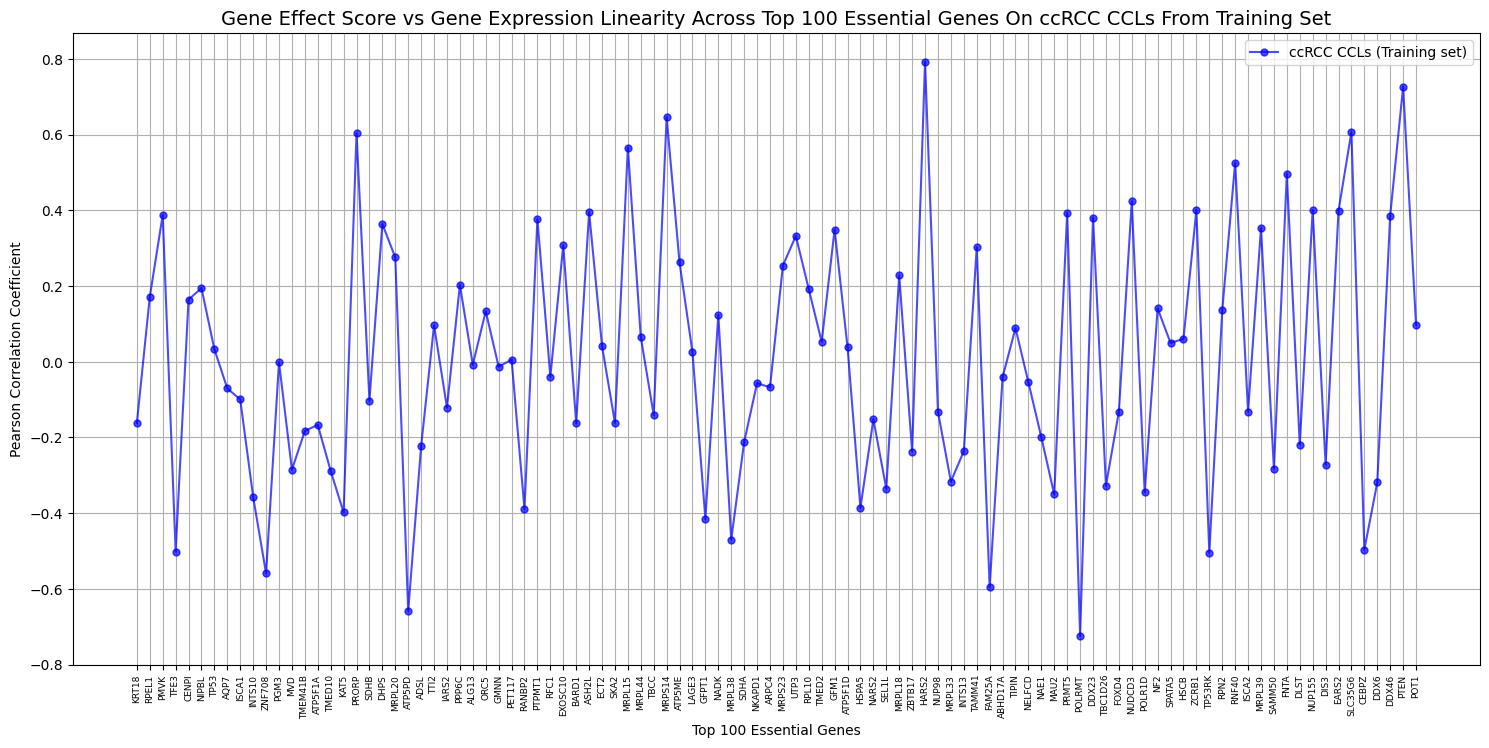

Mean Pearson Correlation Coefficients across top 100 essential genes: 0.2715318866511475


In [18]:
lf.LinePlot(ccRCC_top_100_essential_gene_linearity, 
            {"Linearity": "blue"}, 
            axes_labels=["Top 100 Essential Genes", 
                         "Pearson Correlation Coefficient"], 
            main_title="Gene Effect Score vs Gene Expression Linearity Across Top 100 Essential Genes On ccRCC CCLs From Training Set",
            legend_titles={"corr": "ccRCC CCLs (Training set)"})

print("Mean Pearson Correlation Coefficients across top 100 essential genes: {0}".format(abs(ccRCC_top_100_essential_gene_linearity["corr"]).mean()))

In [19]:
ccRCC_top100_essential_gene_models = lf.ComputeGeneLinearModels(ccRCC_X_train, ccRCC_Y_train, top100_essential_genes)
ccRCC_top100_essential_gene_preds, ccRCC_top100_essential_gene_RMSE = lf.ComputeGenePredictions(ccRCC_X_test, ccRCC_Y_test, ccRCC_top100_essential_gene_models)

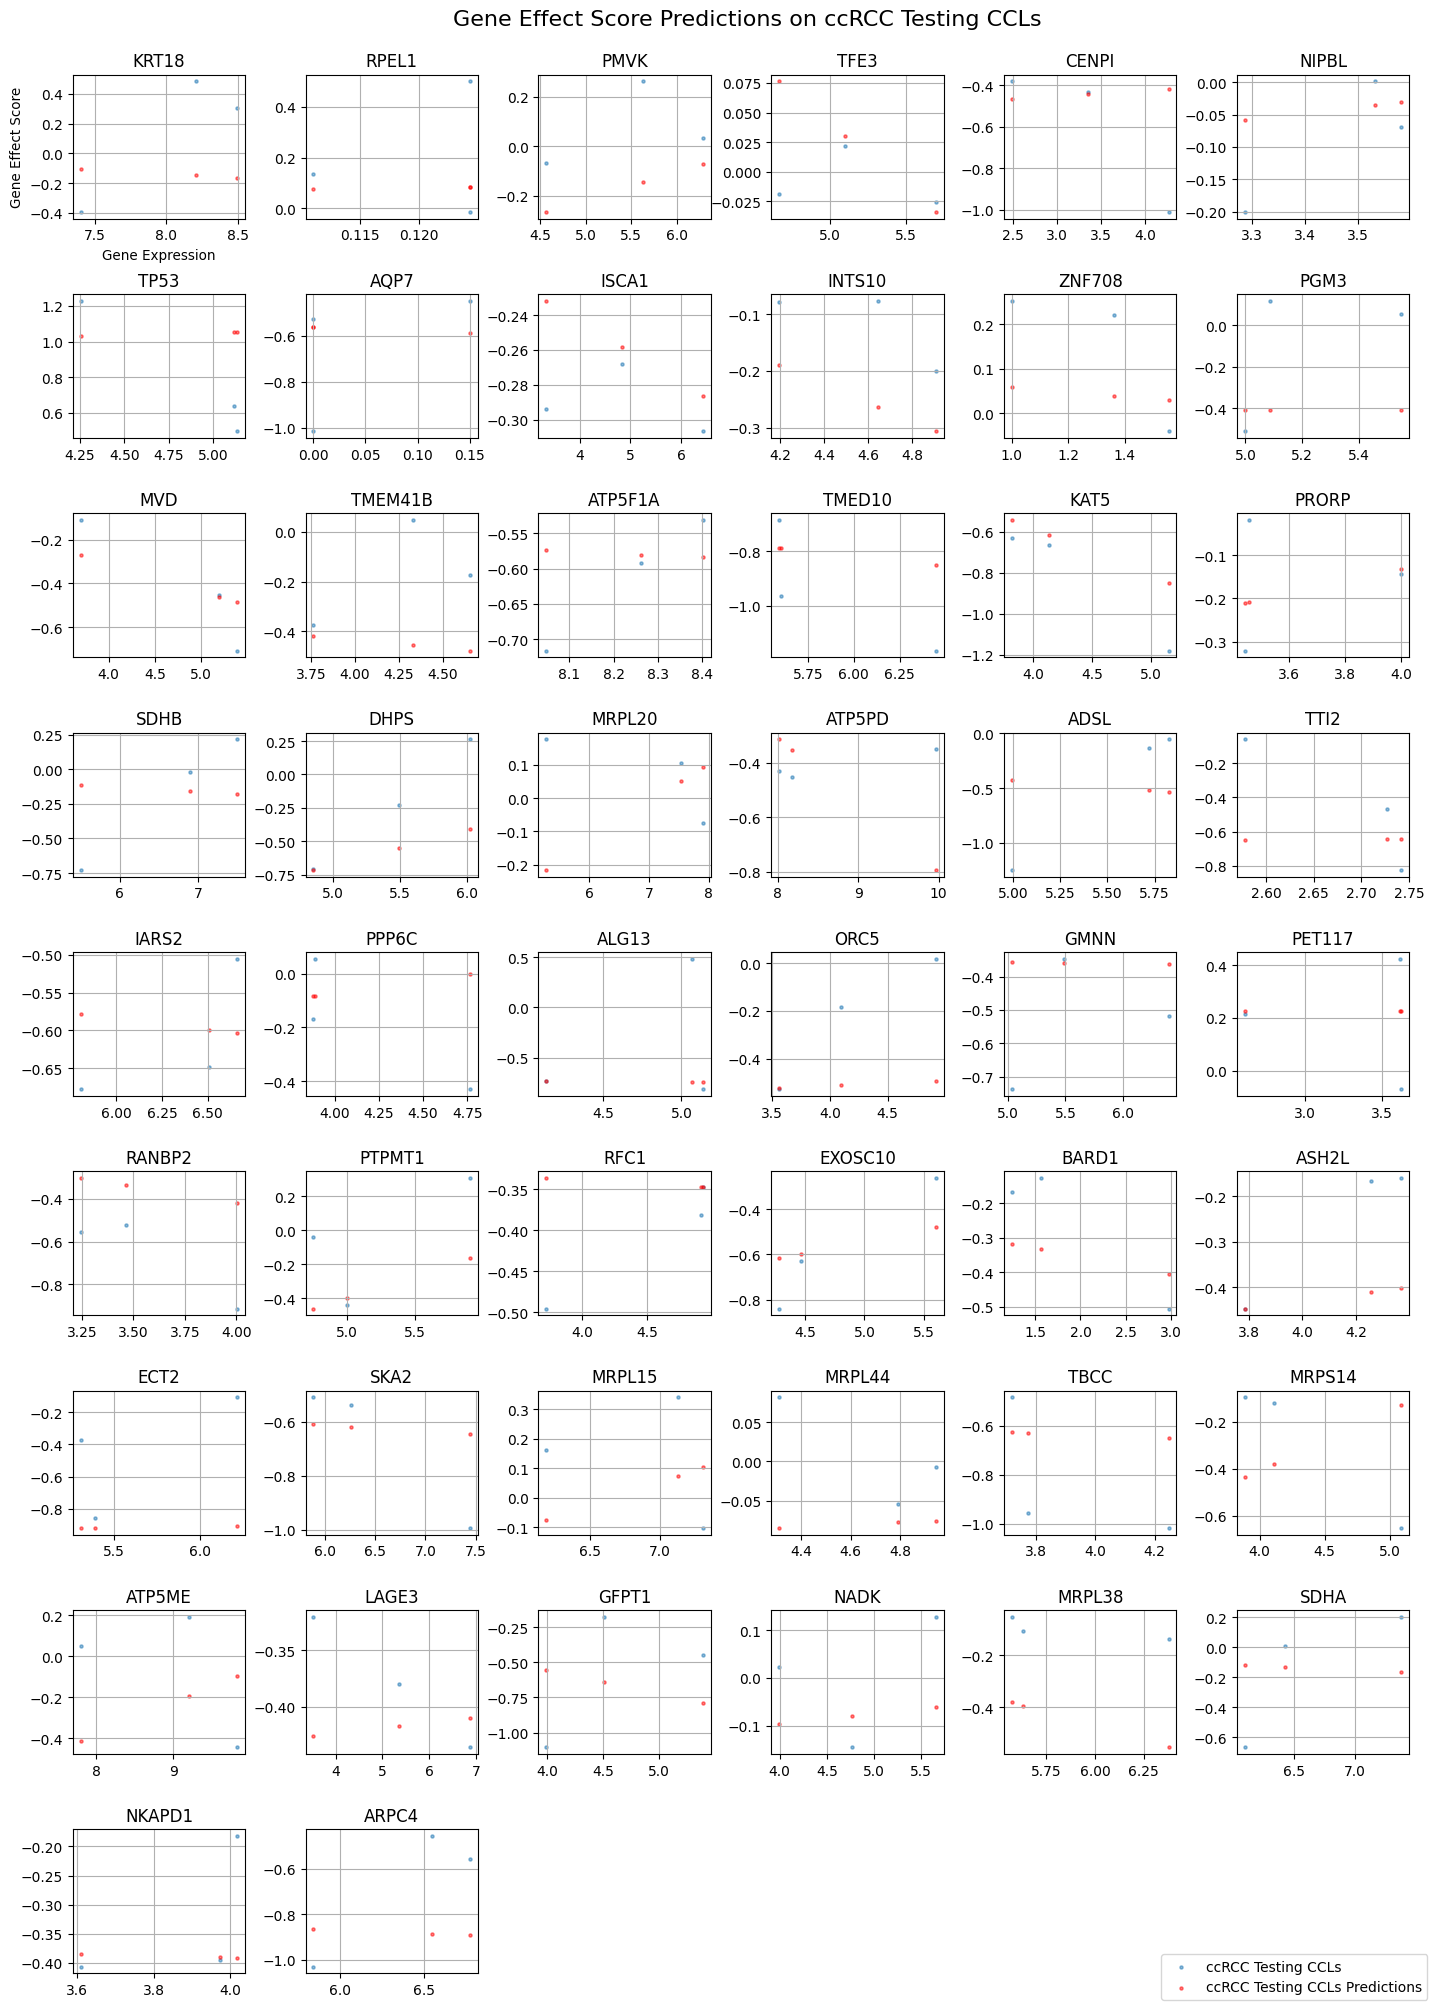

In [20]:
lf.GeneRelMiniPlot(ccRCC_X_test, ccRCC_Y_test, top100_essential_genes[:50],
                   rel2_X=ccRCC_X_test,
                   rel2_Y=ccRCC_top100_essential_gene_preds,
                   main_title="Gene Effect Score Predictions on ccRCC Testing CCLs",
                   axes_labels=["Gene Expression", "Gene Effect Score"],
                   axis_label_fontsize=9.75,
                   legend_titles={
                       "rel1": "ccRCC Testing CCLs", "rel2": "ccRCC Testing CCLs Predictions"},
                   sizeProps=[0.9475, 0.01, 0.99, 0],
                   wspace=0.35,
                   hspace=0.525)

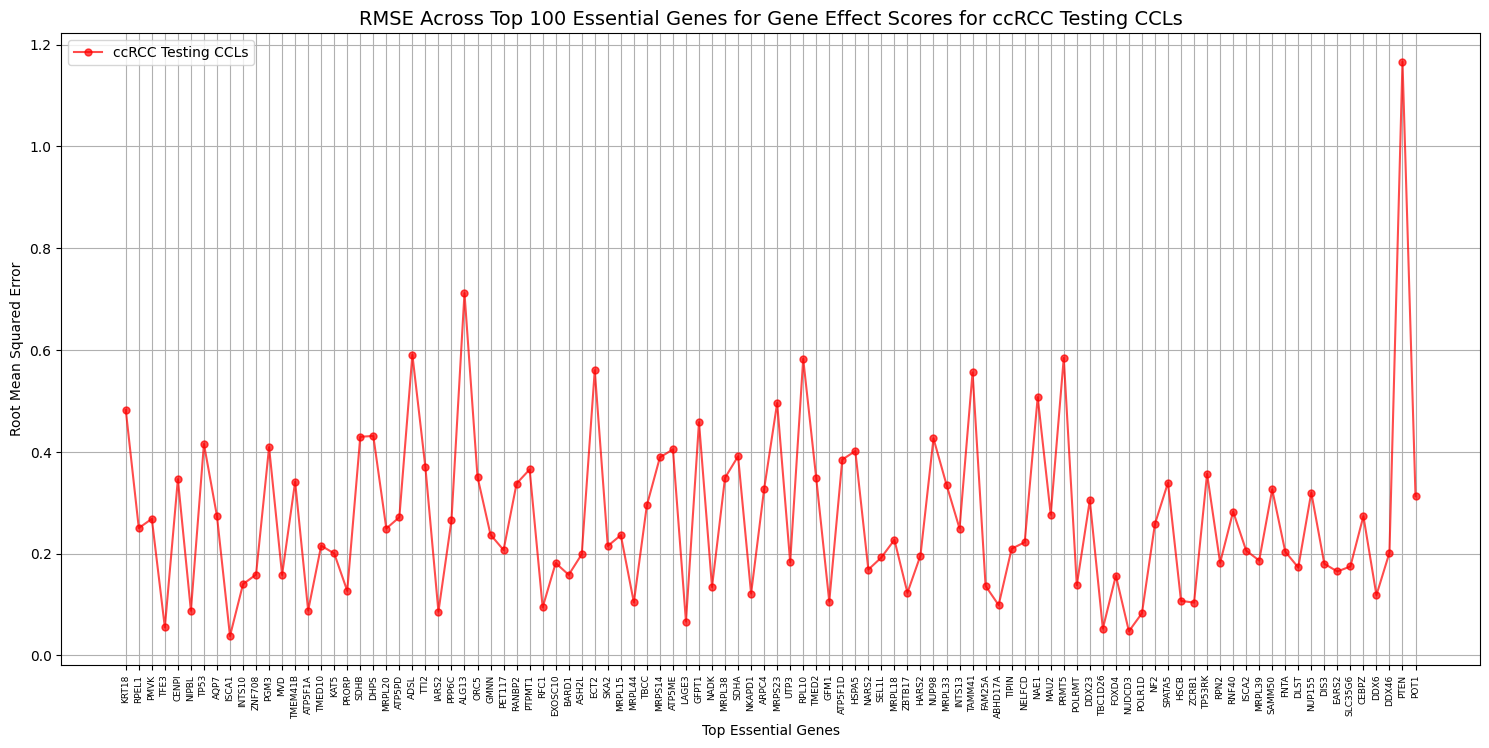

In [21]:
lf.LinePlot(ccRCC_top100_essential_gene_RMSE, 
            {"RMSE": "red"}, 
            axes_labels=["Top Essential Genes", 
                         "Root Mean Squared Error"], 
            main_title="RMSE Across Top 100 Essential Genes for Gene Effect Scores for ccRCC Testing CCLs",
            legend_titles={"RMSE": "ccRCC Testing CCLs"})

In [22]:
print("Average RMSE for predicted gene effect scores on testing subset of ccRCC CCLs: {0:.4}".format(ccRCC_top100_essential_gene_RMSE["RMSE"].mean()))

Average RMSE for predicted gene effect scores on testing subset of ccRCC CCLs: 0.2707


## DepMap Trained Linear Models on tRCC CCLs

### Full DepMap Linear Models tRCC Gene Effect Score Predictions

In [23]:
depmap_tRCC_essential_gene_preds, depmap_tRCC_essential_gene_RMSE = lf.ComputeGenePredictions(tRCC_gene_exp, tRCC_chronos_gene_effects, depmap_top100_essential_gene_models)

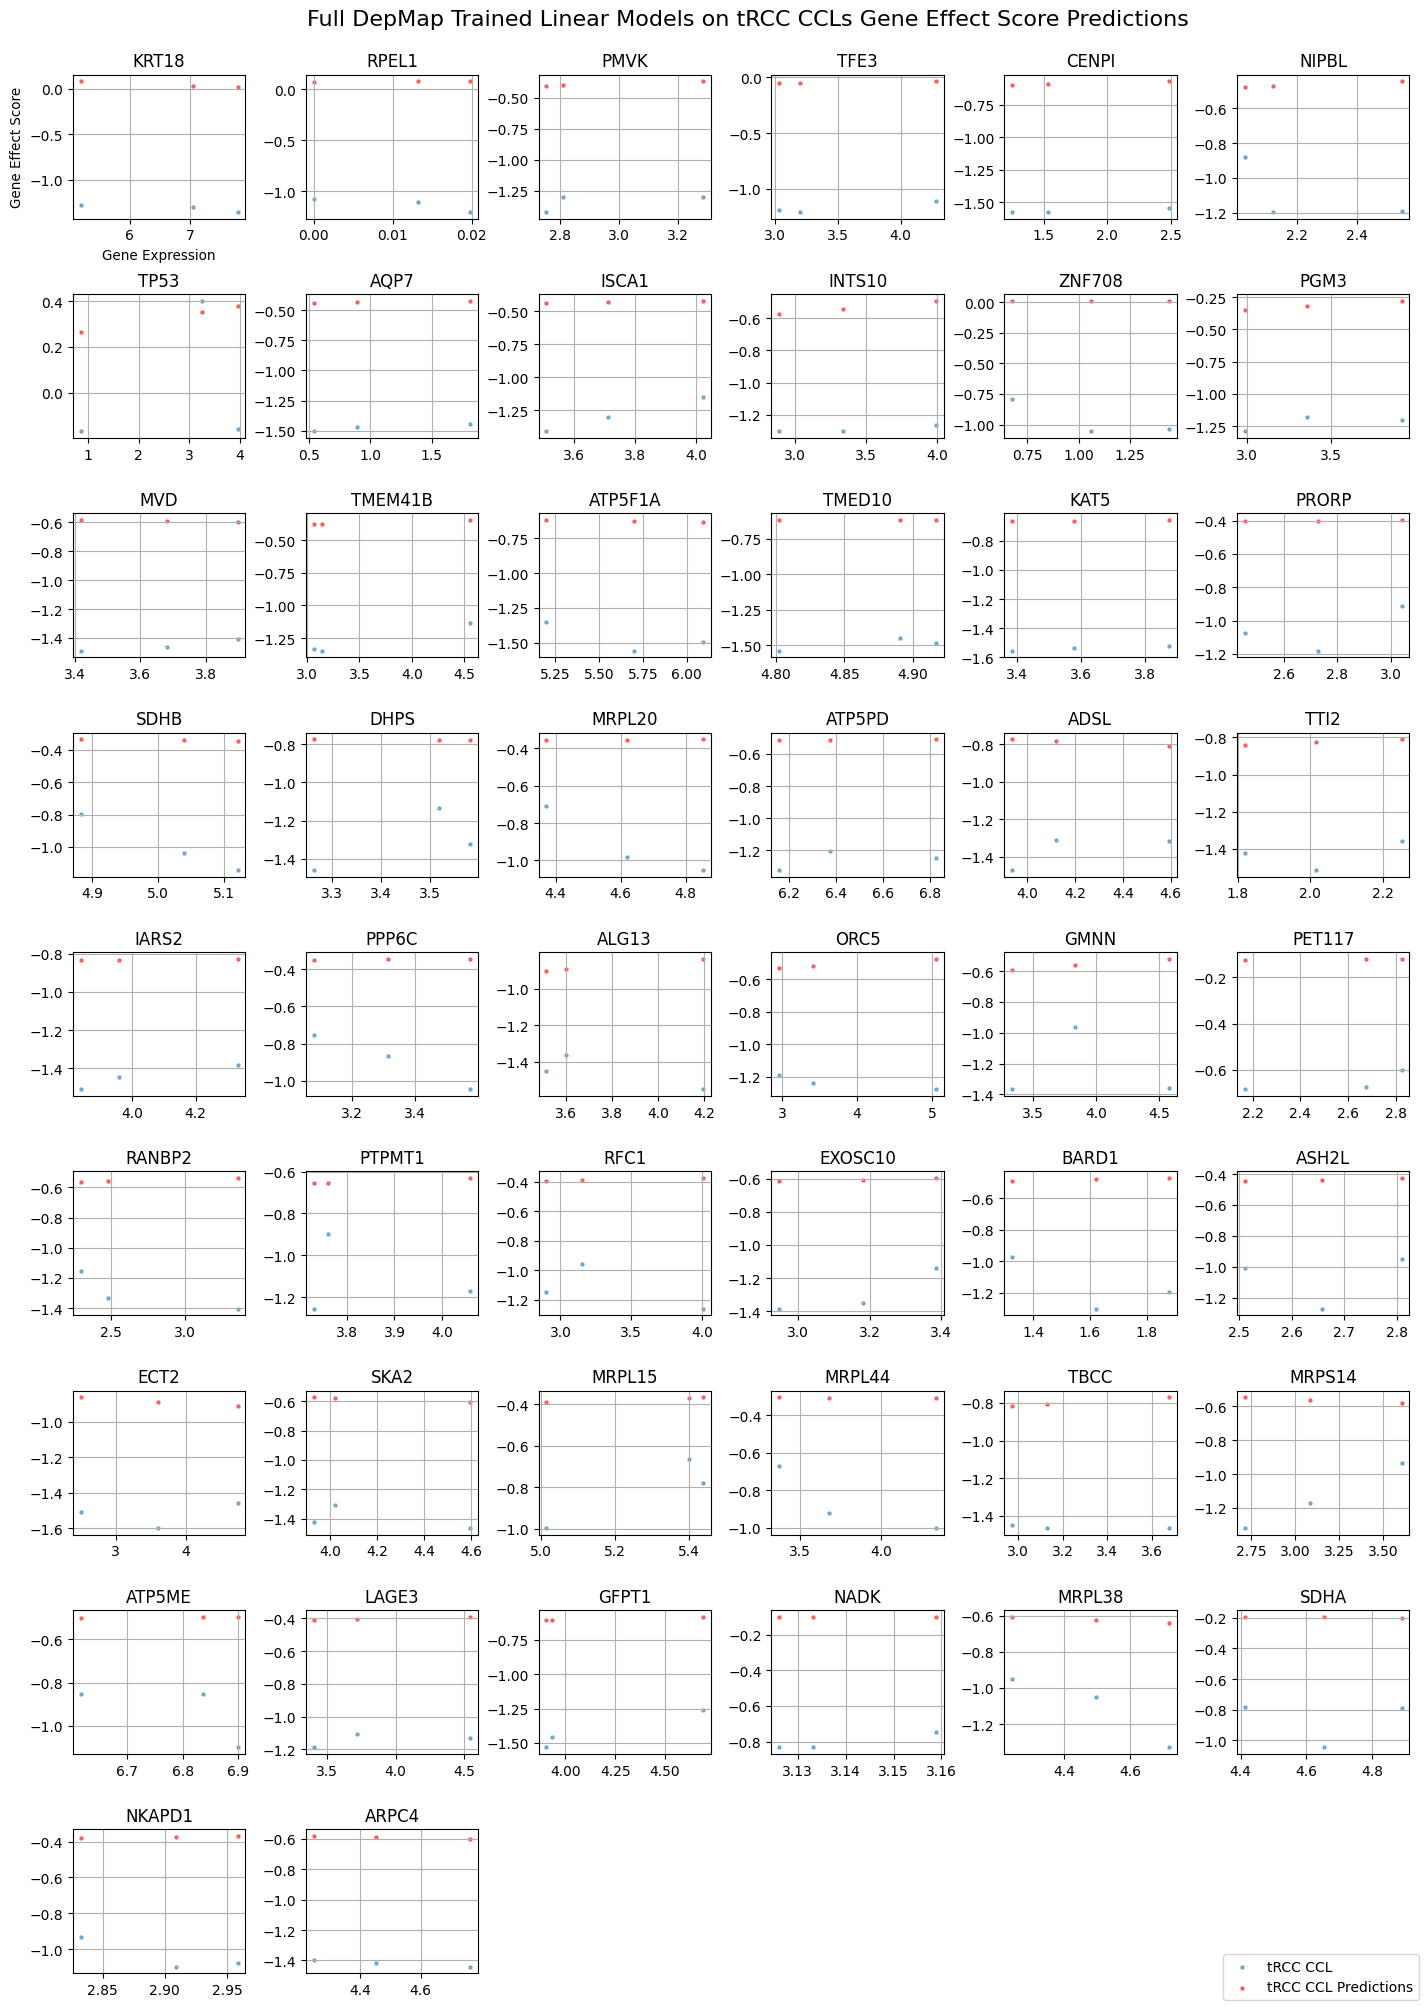

In [24]:
lf.GeneRelMiniPlot(tRCC_gene_exp, tRCC_chronos_gene_effects, top100_essential_genes[:50],
                   rel2_X=tRCC_gene_exp,
                   rel2_Y=depmap_tRCC_essential_gene_preds,
                   main_title="Full DepMap Trained Linear Models on tRCC CCLs Gene Effect Score Predictions",
                   axes_labels=["Gene Expression", "Gene Effect Score"],
                   axis_label_fontsize=9.75,
                   legend_titles={
                       "rel1": "tRCC CCL", "rel2": "tRCC CCL Predictions"},
                   sizeProps=[0.9475, 0.01, 0.99, 0],
                   wspace=0.35,
                   hspace=0.525)

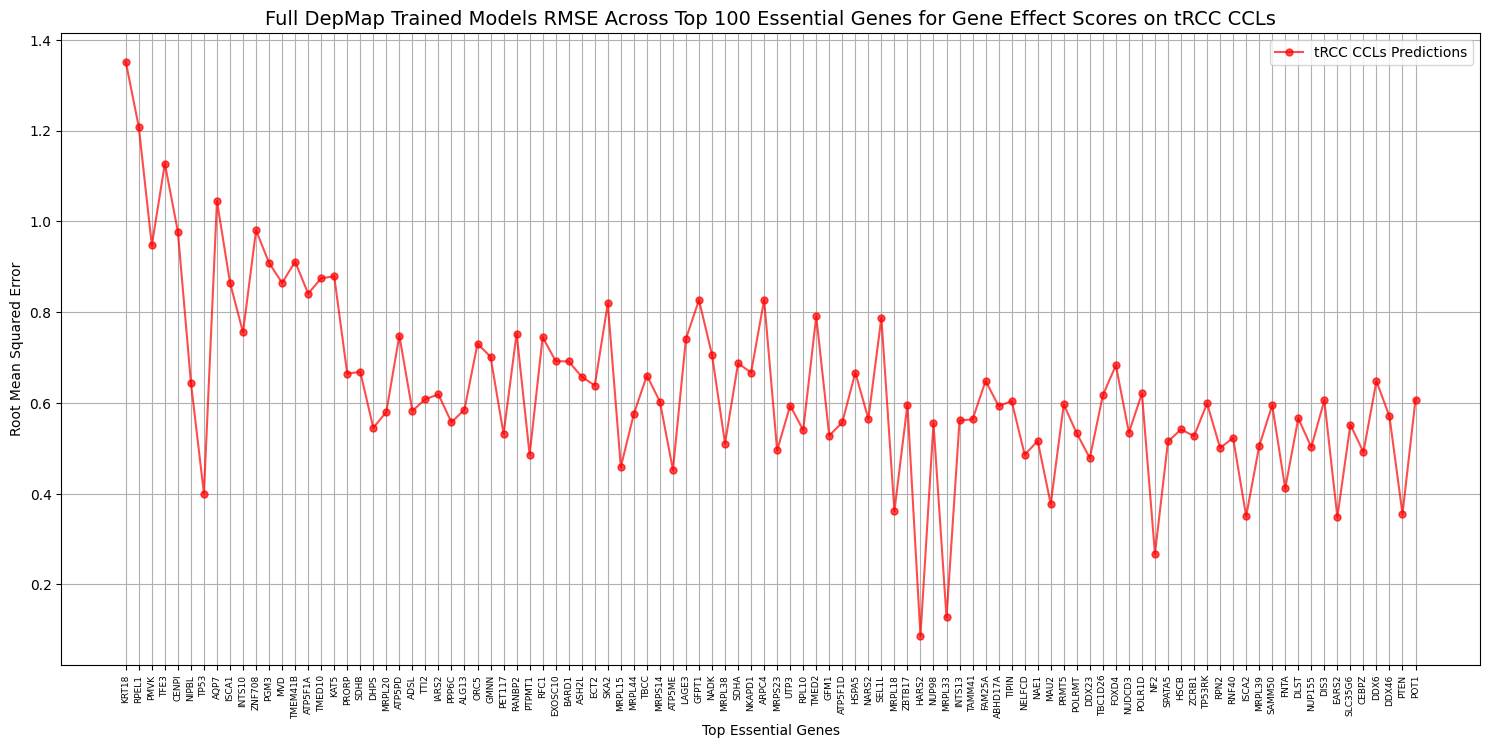

Average RMSE for predicted gene effect scores on tRCC CCLs: 0.6315


In [25]:
lf.LinePlot(depmap_tRCC_essential_gene_RMSE, 
            {"RMSE": "red"}, 
            axes_labels=["Top Essential Genes", 
                         "Root Mean Squared Error"], 
            main_title="Full DepMap Trained Models RMSE Across Top 100 Essential Genes for Gene Effect Scores on tRCC CCLs",
            legend_titles={"RMSE": "tRCC CCLs Predictions"})

print("Average RMSE for predicted gene effect scores on tRCC CCLs: {0:.4}".format(depmap_tRCC_essential_gene_RMSE["RMSE"].mean()))

### RCC CCLs Linear Models tRCC Gene Effect Score Predictions

In [26]:
RCC_tRCC_essential_gene_preds, RCC_tRCC_essential_gene_RMSE = lf.ComputeGenePredictions(tRCC_gene_exp, tRCC_chronos_gene_effects, RCC_top100_essential_gene_models)

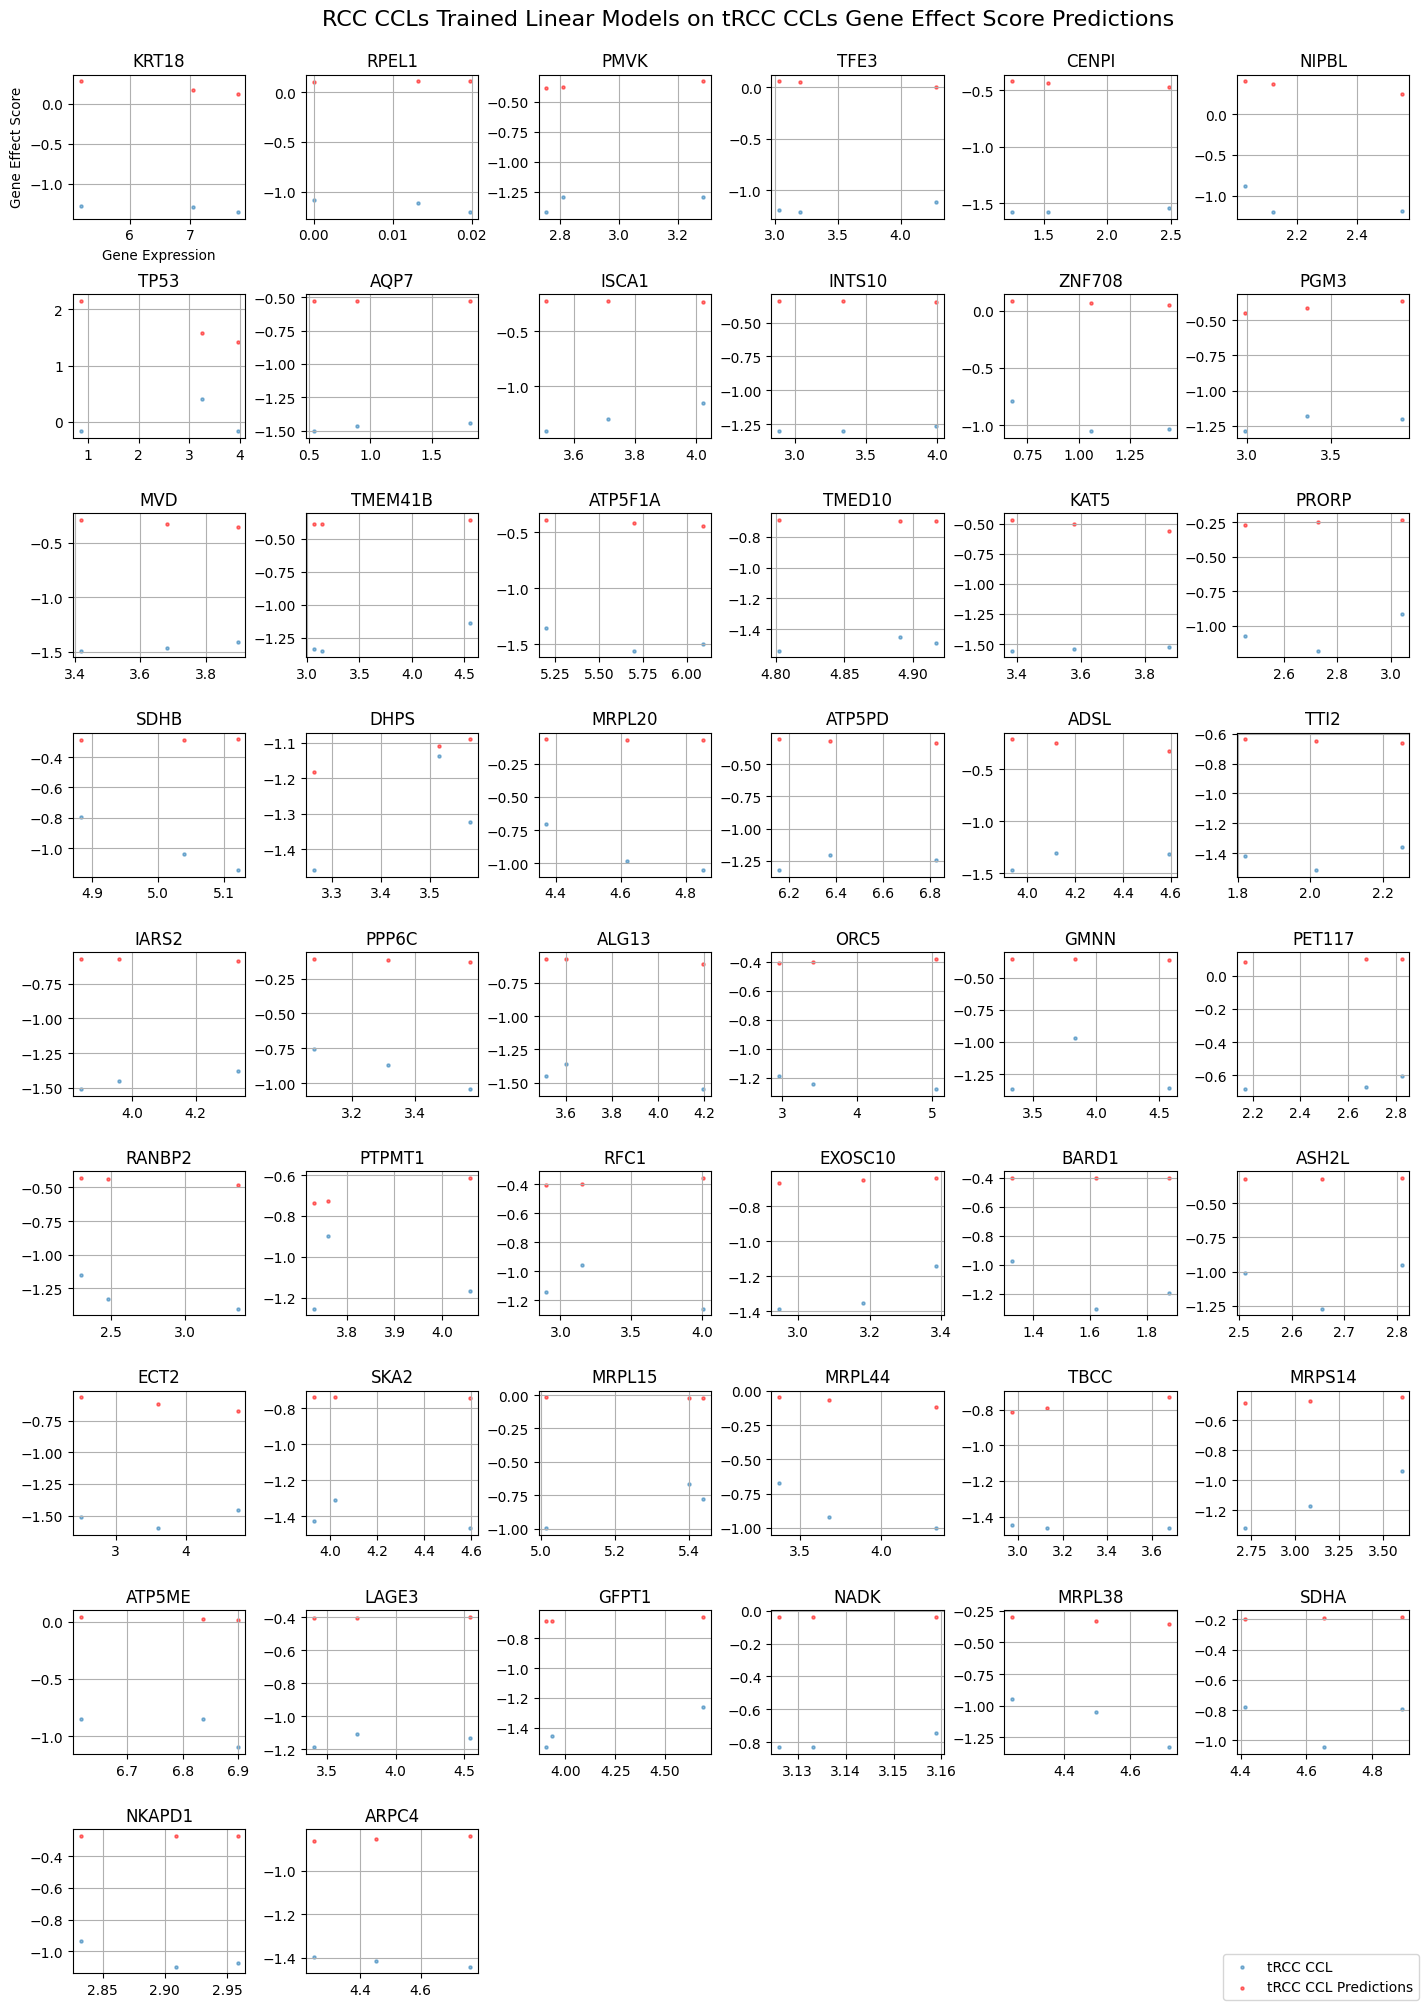

In [27]:
lf.GeneRelMiniPlot(tRCC_gene_exp, tRCC_chronos_gene_effects, top100_essential_genes[:50],
                   rel2_X=tRCC_gene_exp,
                   rel2_Y=RCC_tRCC_essential_gene_preds,
                   main_title="RCC CCLs Trained Linear Models on tRCC CCLs Gene Effect Score Predictions",
                   axes_labels=["Gene Expression", "Gene Effect Score"],
                   axis_label_fontsize=9.75,
                   legend_titles={
                       "rel1": "tRCC CCL", "rel2": "tRCC CCL Predictions"},
                   sizeProps=[0.9475, 0.01, 0.99, 0],
                   wspace=0.35,
                   hspace=0.525)

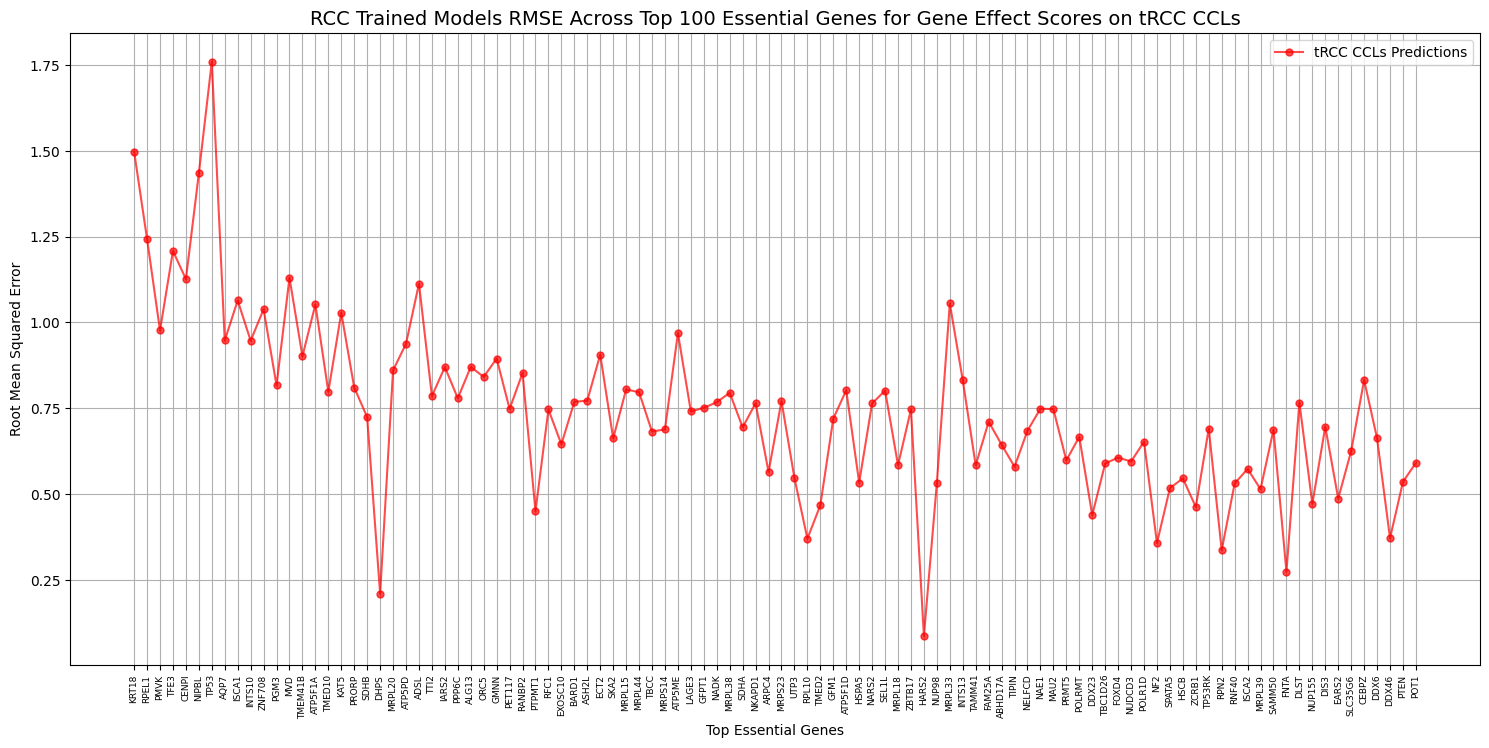

Average RMSE for predicted gene effect scores on tRCC CCLs: 0.742


In [28]:
lf.LinePlot(RCC_tRCC_essential_gene_RMSE, 
            {"RMSE": "red"}, 
            axes_labels=["Top Essential Genes", 
                         "Root Mean Squared Error"], 
            main_title="RCC Trained Models RMSE Across Top 100 Essential Genes for Gene Effect Scores on tRCC CCLs",
            legend_titles={"RMSE": "tRCC CCLs Predictions"})

print("Average RMSE for predicted gene effect scores on tRCC CCLs: {0:.4}".format(RCC_tRCC_essential_gene_RMSE["RMSE"].mean()))

### ccRCC CCLs Linear Models tRCC Gene Effect Score Predictions

In [29]:
ccRCC_tRCC_essential_gene_preds, ccRCC_tRCC_essential_gene_RMSE = lf.ComputeGenePredictions(tRCC_gene_exp, tRCC_chronos_gene_effects, ccRCC_top100_essential_gene_models)

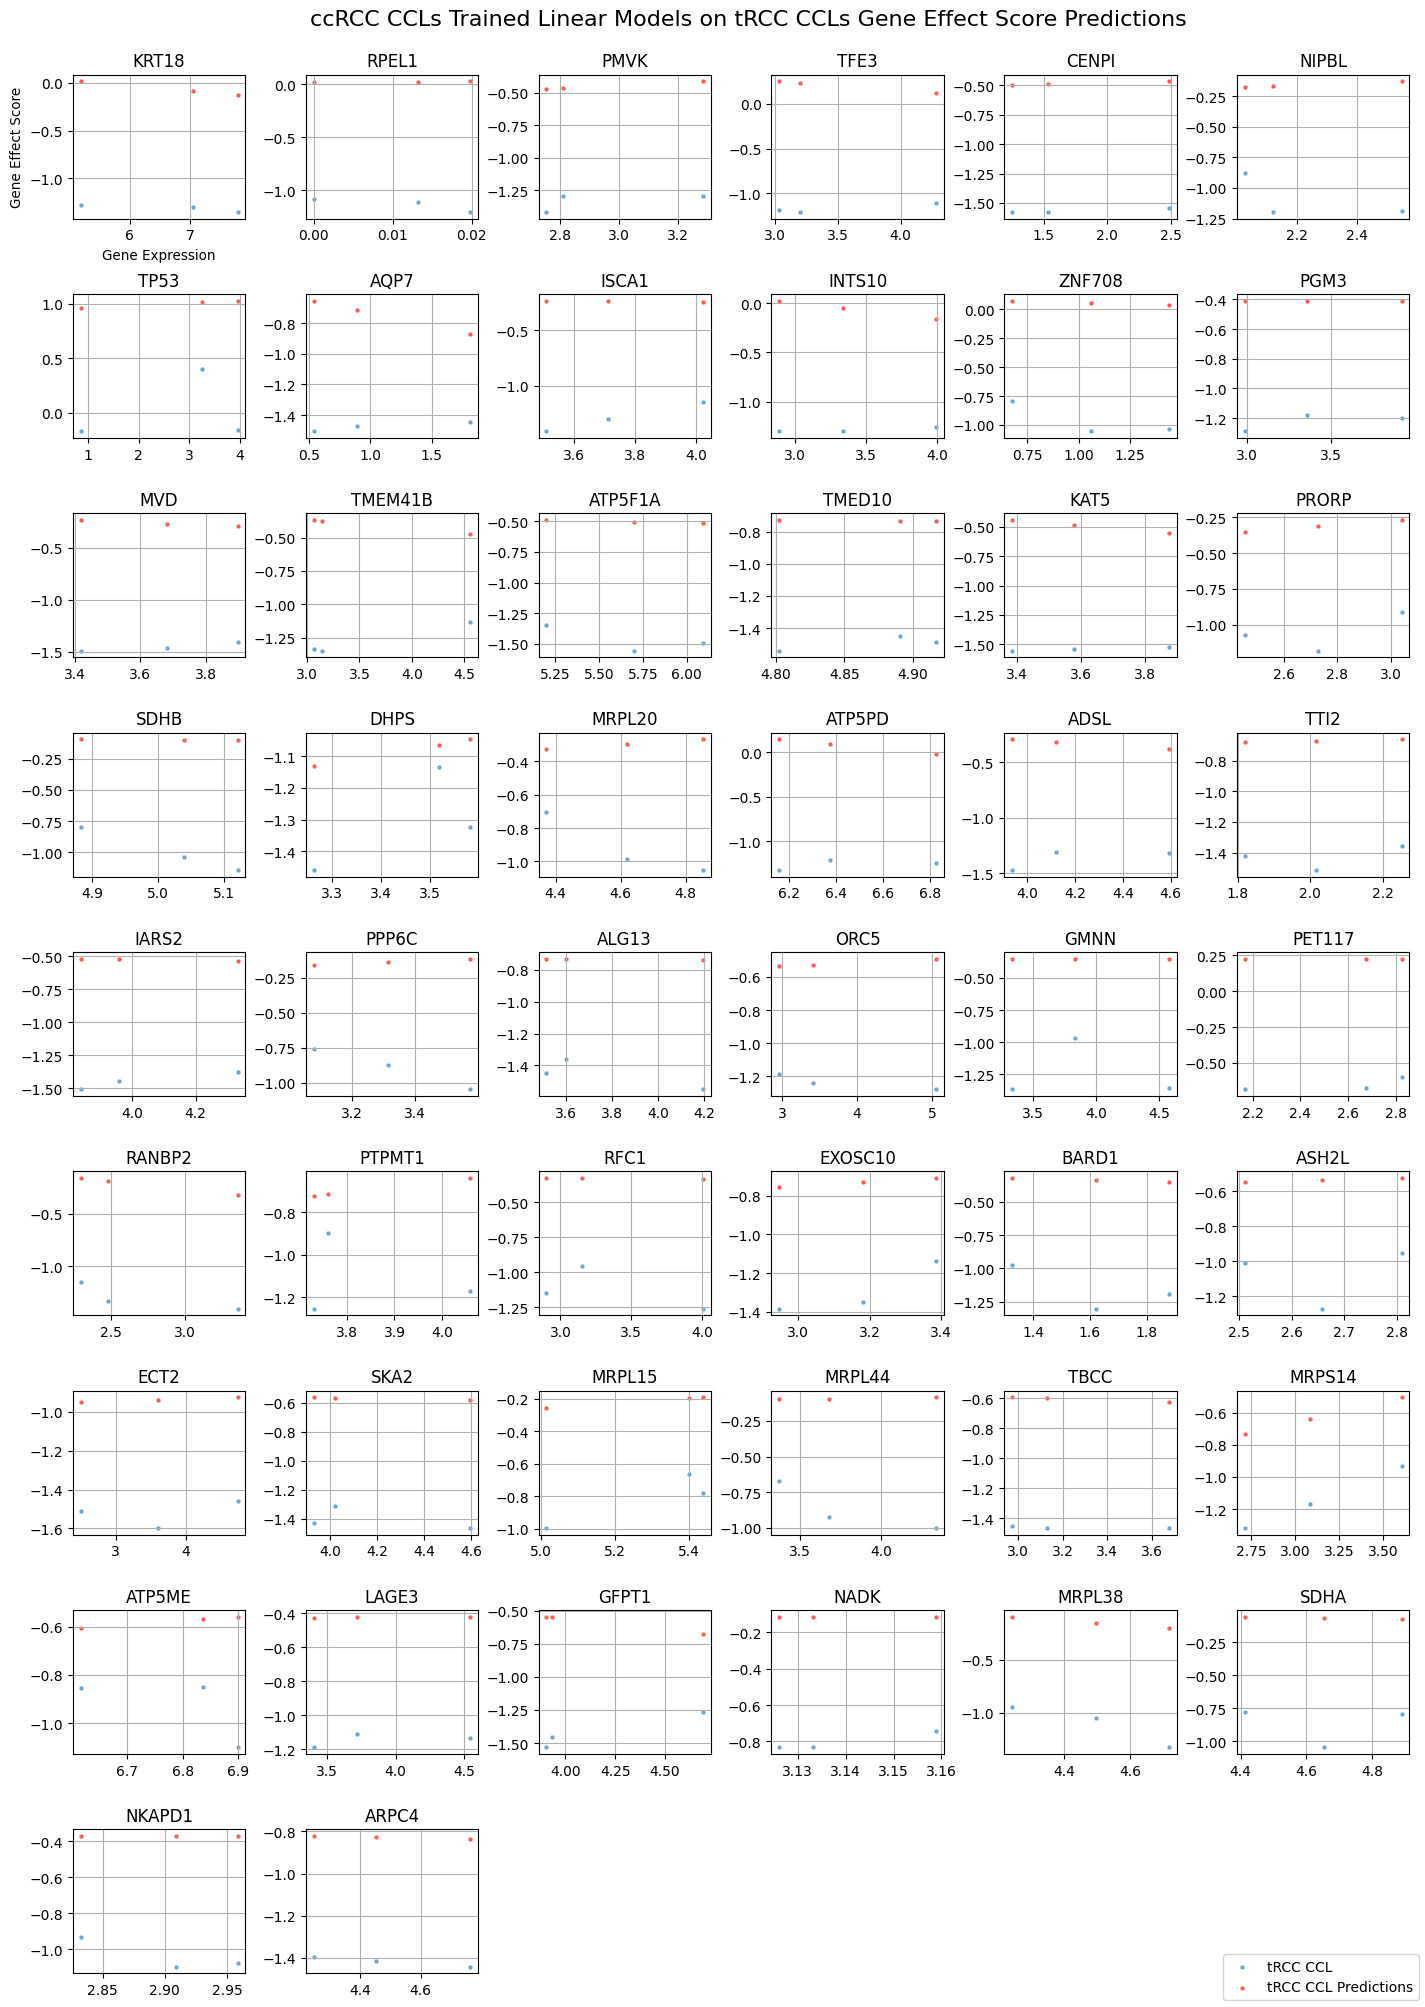

In [30]:
lf.GeneRelMiniPlot(tRCC_gene_exp, tRCC_chronos_gene_effects, top100_essential_genes[:50],
                   rel2_X=tRCC_gene_exp,
                   rel2_Y=ccRCC_tRCC_essential_gene_preds,
                   main_title="ccRCC CCLs Trained Linear Models on tRCC CCLs Gene Effect Score Predictions",
                   axes_labels=["Gene Expression", "Gene Effect Score"],
                   axis_label_fontsize=9.75,
                   legend_titles={
                       "rel1": "tRCC CCL", "rel2": "tRCC CCL Predictions"},
                   sizeProps=[0.9475, 0.01, 0.99, 0],
                   wspace=0.35,
                   hspace=0.525)

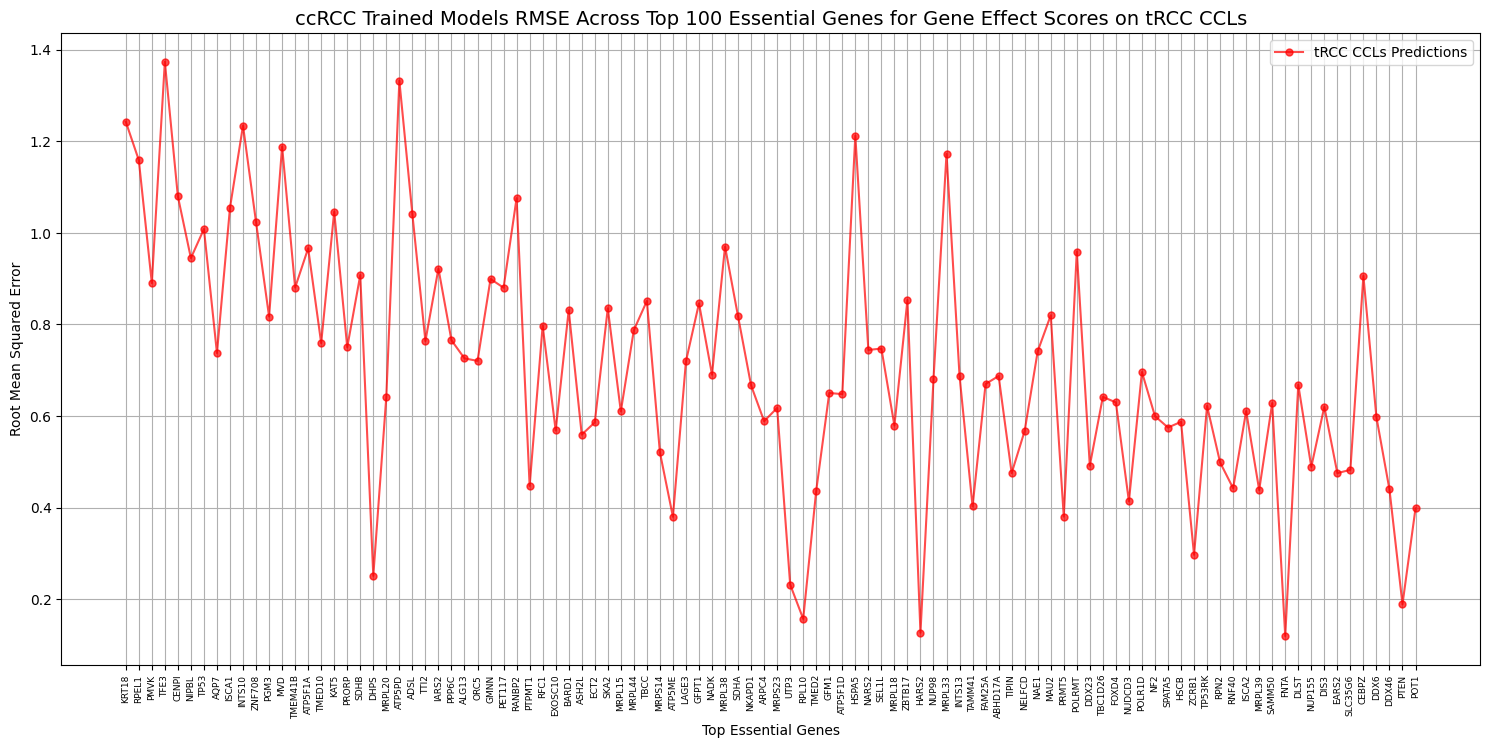

Average RMSE for predicted gene effect scores on tRCC CCLs: 0.7095


In [31]:
lf.LinePlot(ccRCC_tRCC_essential_gene_RMSE, 
            {"RMSE": "red"}, 
            axes_labels=["Top Essential Genes", 
                         "Root Mean Squared Error"], 
            main_title="ccRCC Trained Models RMSE Across Top 100 Essential Genes for Gene Effect Scores on tRCC CCLs",
            legend_titles={"RMSE": "tRCC CCLs Predictions"})

print("Average RMSE for predicted gene effect scores on tRCC CCLs: {0:.4}".format(ccRCC_tRCC_essential_gene_RMSE["RMSE"].mean()))